# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch, port_ch_to_mlp, proxy_train_mlp, get_CSMIA_case_by_case_results, CSMIA_attack
from data_utils import oneHotCatVars
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices, get_disparity_by_subgroup
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

# Load Data

In [3]:
class MIAExperiment:
    def __init__(self, *args, **kwargs):
        self.sampling_condition_dict = kwargs.get('sampling_condition_dict', None)
        self.sensitive_column = kwargs.get('sensitive_column', 'MAR')

        for key, value in kwargs.items():
            setattr(self, key, value)

        if not hasattr(self, 'name'):
            self.name = 'Census19'
        self.ds = data_utils.CensusWrapper(
                    filter_prop="none", ratio=float(0.5), split="all", name=self.name, sampling_condition_dict=self.sampling_condition_dict, sensitive_column=self.sensitive_column,
                    additional_meta=None)
        (self.x_tr, self.y_tr), (self.x_te, self.y_te), self.cols = self.ds.load_data()
        self.X_train = pd.DataFrame(self.x_tr, columns=self.cols)
        self.X_test = pd.DataFrame(self.x_te, columns=self.cols)
        self.y_tr_onehot = self.ds.ds.y_enc.transform(self.y_tr).toarray()
        self.y_te_onehot = self.ds.ds.y_enc.transform(self.y_te).toarray()

    def __str__(self):
        return self.ds.ds.filenameroot
    
    def __repr__(self):
        return self.ds.ds.filenameroot
    
    def get_value_count_report(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # print(df[df[self.subgroup_column] == value].columns)
            # print(df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]])
            new_df = df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]]
            print(new_df.value_counts())
            # print(df[df[self.subgroup_column == value]][[self.sensitive_column, self.y_column]].corr())


    def get_mutual_information_between_sens_and_y(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        mutual_info_dict = {}
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # All the features except y column
            X = df[df[self.subgroup_column] == value].drop([self.y_column], axis=1)
            y = df[df[self.subgroup_column] == value][[self.y_column]]
            # print(mutual_info_classif(X, y, discrete_features=True))
            mutual_info_dict[value] = mutual_info_classif(X, y, discrete_features=True)
        return mutual_info_dict

In [4]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


In [43]:
def get_indices_by_group_condition(X, conditions):
    X_new = X.copy()
    for key, value in conditions.items():
        X_new = X_new.loc[X_new[f"{key}_{value}"] == 1]
    return X_new.index

def get_corr_btn_sens_and_out_per_subgroup(X, y, conditions):
    indices = get_indices_by_group_condition(X, conditions)
    X_new = X.loc[indices]
    y_new = y[indices]
    X_new = X_new[['MAR_1']].to_numpy().ravel()
    y_new = y_new.ravel()
    return np.corrcoef(X_new, y_new)[0, 1]

In [44]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.4)']
print(get_corr_btn_sens_and_out_per_subgroup(experiment.X_train, experiment.y_tr, {'SEX': 0}))
print(get_corr_btn_sens_and_out_per_subgroup(experiment.X_test, experiment.y_te, {'SEX': 0}))
print(get_corr_btn_sens_and_out_per_subgroup(experiment.X_test, experiment.y_te, {'SEX': 1}))

-0.09999999999999996
-0.39999999999999986
-0.39999999999999986


In [ ]:
experiment.X_test.shape

In [ ]:
for experiment_key in experiments:
    get_corr_btn_sens_and_output_per_subgroup(experiments[experiment_key])

# Load and Train Target Model

In [ ]:
base_model = model_utils.get_model(max_iter=500)

In [ ]:
save_model = False

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_benign.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf_benign = copy.deepcopy(base_model)
        experiment.clf_benign.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

In [ ]:
model_utils.save_model(experiment.clf_benign, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_benign.pkl')

Train Target Model on test set only

In [7]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN
Loaded classifier for experiment from file: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [79]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test_mlp = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN
Loaded classifier for experiment from file: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [ ]:
save_model = True

from sklearn.tree import DecisionTreeClassifier

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    experiment.clf_only_on_test = DecisionTreeClassifier(random_state=42, max_depth=7)
    experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

In [ ]:
clf = experiment.clf_only_on_test

train_acc = 100 * clf.score(experiment.X_train, experiment.ds.ds.y_enc.transform(experiment.y_tr).toarray())
test_acc = 100 * clf.score(experiment.X_test, experiment.ds.ds.y_enc.transform(experiment.y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

In [ ]:
experiment.clf_only_on_test.predict_proba(experiment.X_test)

In [ ]:
experiment.clf_only_on_test_mlp.predict_proba(experiment.X_test)

Train Target Model on both train set and test set

In [ ]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf = model_utils.get_model(max_iter=500)
        experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

        if save_model:
            model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

# Fed Training

In [ ]:
# experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.4)']
test_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train'] == 0]
test_df = test_df.drop(['is_train'], axis=1)

test_df = test_df.drop([experiment.sensitive_column], axis=1)
experiment.y_column = experiment.ds.ds.meta['y_column']
test_df = test_df.drop([experiment.y_column], axis=1)

temp_np = test_df.to_numpy()[:50000, :]
temp_np = temp_np.astype(np.float32)
temp_np_1 = np.expand_dims(temp_np, 0)
temp_np_2 = np.expand_dims(temp_np, 1)
experiment.dist_matrix = np.count_nonzero(temp_np_1 - temp_np_2, axis=2)

In [8]:
experiment.y_column = experiment.ds.ds.meta['y_column']

In [ ]:
np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_dist_matrix_wout_sens_col.npy', experiment.dist_matrix)

In [ ]:
experiment.dist_matrix = np.load(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_dist_matrix_wout_sens_col.npy')

In [9]:
sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
incorrect_indices = ~correct_indices
case_2_correct_indices = np.where(np.logical_and(case_indices[2], correct_indices))[0]
case_2_incorrect_indices = np.where(np.logical_and(case_indices[2], incorrect_indices))[0]
case_1_correct_indices = np.where(np.logical_and(case_indices[1], correct_indices))[0]
case_1_incorrect_indices = np.where(np.logical_and(case_indices[1], incorrect_indices))[0]
case_3_correct_indices = np.where(np.logical_and(case_indices[3], correct_indices))[0]
case_3_incorrect_indices = np.where(np.logical_and(case_indices[3], incorrect_indices))[0]

In [ ]:
conf_scores = np.max(experiment.clf_only_on_test.predict_proba(experiment.X_test), axis=1)
sensitive_column = experiment.ds.ds.meta["sensitive_column"]
y_val = experiment.y_te.ravel()
sens_val = experiment.X_test[[f'{sensitive_column}_1']].to_numpy().ravel()
X_temp = experiment.X_test.copy()
X_temp[f'{sensitive_column}_0'] = 1 - X_temp[f'{sensitive_column}_0']
X_temp[f'{sensitive_column}_1'] = 1 - X_temp[f'{sensitive_column}_1']
conf_scores_flipped = np.max(experiment.clf_only_on_test.predict_proba(X_temp), axis=1)

In [61]:
def get_corr_btn_sens_and_out_for_indices(X, y, indices):
    X_new = X.loc[indices]
    y_new = y[indices]
    X_new = X_new[['MAR_1']].to_numpy().ravel()
    y_new = y_new.ravel()
    return np.corrcoef(X_new, y_new)[0, 1]

def get_percentage_of_same_sens_val_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
    return (X.iloc[dist_2_neighbours][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_val).mean()

# def find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=4):
#     test_df = orig_df.copy()
#     test_df.loc[index, experiment.sensitive_column] = orig_sens_pred
#     # test_df = test_df.drop([experiment.sensitive_column], axis=1)
#     test_df = test_df.drop([experiment.y_column], axis=1)

#     train_df = aux_df.copy()
#     # train_df = train_df.drop([experiment.sensitive_column], axis=1)
#     train_df = train_df.drop([experiment.y_column], axis=1)

#     temp_np = train_df.to_numpy()[:50000, :]
#     temp_np = temp_np.astype(np.float32)
#     temp_np_1 = np.expand_dims(temp_np, 0)

#     temp_np = test_df.to_numpy()[index:index+1, :]
#     # temp_np[:, 3] = orig_sens_pred
#     temp_np = temp_np.astype(np.float32)
#     temp_np_2 = np.expand_dims(temp_np, 1)
    
#     dist_matrix = np.count_nonzero(temp_np_1 - temp_np_2, axis=2).ravel()
#     # print(dist_matrix)
    
#     return dist_matrix <= k

def find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=4):
    train_df = orig_df.copy()
    train_df.loc[index, experiment.sensitive_column] = orig_sens_pred
    # test_df = test_df.drop([experiment.sensitive_column], axis=1)
    train_df = train_df.drop([experiment.y_column], axis=1)

    # test_df = aux_df.copy()
    # train_df = train_df.drop([experiment.sensitive_column], axis=1)
    # train_df = train_df.drop([experiment.y_column], axis=1)

    aux_np = aux_df.drop([experiment.y_column], axis=1).to_numpy()
    aux_np = aux_np.astype(np.float32)
    aux_np = np.expand_dims(aux_np, 0)

    temp_np = train_df.to_numpy()[index:index+1, :]
    # temp_np[:, 3] = orig_sens_pred
    temp_np = temp_np.astype(np.float32)
    temp_np_2 = np.expand_dims(temp_np, 1)
    
    dist_matrix = np.count_nonzero(aux_np - temp_np_2, axis=2).ravel()
    # print(dist_matrix)
    
    return dist_matrix <= k

def get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(X, y, orig_df, aux_df, orig_sens_pred, orig_y, index, k=4):
    dist_2_neighbours = find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=k)
    # print(np.where(dist_2_neighbours)[0][:50])
    dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
    dist_2_neighbours_w_same_y_indices = (orig_y == dist_2_neighbours_y_values)
    # print(dist_2_neighbours)
    # print(orig_sens_pred)
    # orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
    # return (X.iloc[dist_2_neighbours][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_pred).mean()
    return (X.iloc[dist_2_neighbours].iloc[dist_2_neighbours_w_same_y_indices][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_pred).mean()

# def get_percentage_of_same_sens_val_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
#     dist_2_neighbours = dist_matrix[index] <= k
#     X_temp = X.iloc[dist_2_neighbours]
#     orig_y = y[index]
#     dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
#     # print(dist_2_neighbours_y_values)
#     dist_2_neighbours_w_same_y_indices = (orig_y == dist_2_neighbours_y_values)
#     orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
#     return (X_temp.iloc[dist_2_neighbours_w_same_y_indices][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_val).mean()

def get_percentage_of_same_y_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    X_temp = X.iloc[dist_2_neighbours]
    orig_y = y[index]
    dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
    return np.mean(dist_2_neighbours_y_values == orig_y)

def get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(X, y, sens_pred, case_indices, index, k=3):
    dist_2_neighbours = experiment.dist_matrix[index] <= k
    dominant_sens_val = np.sum(sens_pred[dist_2_neighbours] == 1) > np.sum(sens_pred[dist_2_neighbours] == 0)
    return np.mean(sens_pred[dist_2_neighbours] == dominant_sens_val)

def get_corr_btn_sens_and_out_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    try:
        return get_corr_btn_sens_and_out_for_indices(X, y, dist_2_neighbours)
    except:
        return np.nan

In [42]:
index = case_2_correct_indices[0]
np.where(find_neighbors_within_k_in_train(original_df, aux_df, index, sens_pred[index], k=4))[0]

array([  532,   542,  1262,  2175,  3612,  3617,  4724,  6045,  6199,
        6604,  8384,  9079, 10020, 11087, 11689, 11854, 12006, 12055,
       15183, 28421, 34371])

In [59]:
original_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==0]
original_df = original_df.drop(['is_train'], axis=1)
aux_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train']==1]
aux_df = aux_df.drop(['is_train'], axis=1)

In [62]:
index = case_2_correct_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4))

0.8888888888888888


In [64]:
index = case_2_incorrect_indices[0]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4))

0.12804878048780488


In [35]:
index = case_2_incorrect_indices[0]
print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_test, experiment.y_te, original_df, original_df, sens_pred[index], experiment.y_te[index], index, k=4))

[  4   6   8  15  16  21  24  32  44  45  46  56  59  66  84  87  91  92
  94  97 104 108 111 119 121 127 130 132 138 140 144 150 166 172 177 183
 187 188 189 194 197 199 202 206 214 218 226 229 230 234]
0.20116959064327486


In [55]:
for idx in range(20):
    index = case_2_correct_indices[idx]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4))

0.36363636363636365
0.4099722991689751
0.4241338112305854
0.44902912621359226
0.41796276013143485
0.42
0.4254742547425474
0.32
0.42043067226890757
0.6
0.43359375
0.1111111111111111
0.4198683931224793
0.4107744107744108
0.4473229706390328
0.4163346613545817
0.4408866995073892
0.4195121951219512
0.4378698224852071
0.5102040816326531


In [56]:
for idx in range(20):
    index = case_2_incorrect_indices[idx]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4))

0.583079268292683
0.6666666666666666
0.5832651391162029
0.5844922039612305
0.5792227204783259
0.574749498997996
0.579803328290469
0.5791779409869862
0.5802073998207656
0.5797029702970297
0.5702479338842975
0.5763052208835341
0.5796492961224994
0.5798020806901801
0.5760836151245005
0.5802686080080331
0.5784090909090909
0.5777370777370777
0.5871219913598025
0.5808095515433896


In [ ]:
def get_slope(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment):
    if indices is not None:
        conf_scores, conf_scores_flipped, y_val, sens_val = conf_scores[indices], conf_scores_flipped[indices], y_val[indices], sens_val[indices]

    return [np.polyfit(np.concatenate([conf_scores[np.logical_and(y_val == 1, sens_val == 1)], conf_scores_flipped[np.logical_and(y_val == 1, sens_val == 0)]]), np.concatenate([conf_scores_flipped[np.logical_and(y_val == 1, sens_val == 1)], conf_scores[np.logical_and(y_val == 1, sens_val == 0)]]), 1)[0], np.polyfit(np.concatenate([conf_scores[np.logical_and(y_val == 0, sens_val == 1)], conf_scores_flipped[np.logical_and(y_val == 0, sens_val == 0)]]), np.concatenate([conf_scores_flipped[np.logical_and(y_val == 0, sens_val == 1)], conf_scores[np.logical_and(y_val == 0, sens_val == 0)]]), 1)[0]]

def get_angular_difference(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment):
    slopes = get_slope(indices, conf_scores, conf_scores_flipped, y_val, sens_val, experiment)
    return np.arctan(np.abs(slopes[0] - slopes[1]) / (1 + slopes[0] * slopes[1])) * np.sign(slopes[0] - slopes[1])

In [ ]:
def neighbour_based_CSMIA(model, X_test, y_test, meta, threshold=0.825):
    sens_pred, case_indices = CSMIA_attack(model, X_test, y_test, meta)
    case_2_indices = np.where(case_indices[2])[0]
    # print(case_2_indices)
    neighbor_coeffs = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(X_test, y_test, sens_pred, case_indices, i, k=4) for i in case_2_indices])
    # flip the sens_pred val for indices where neighbor_coeffs is less than 0.9
    neighbor_threshold = threshold
    sens_pred[case_2_indices[neighbor_coeffs < neighbor_threshold]] = 1 - sens_pred[case_2_indices[neighbor_coeffs < neighbor_threshold]]
    return sens_pred, case_indices

In [ ]:
ang_diff = get_angular_difference(None, conf_scores, conf_scores_flipped, y_val, sens_val, experiment)

In [ ]:
ang_diff

In [65]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, original_df, aux_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_1_incorrect_indices[:]])

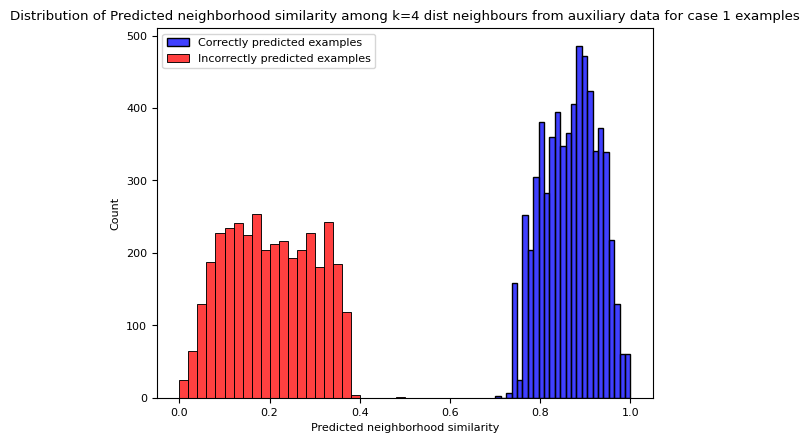

In [66]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from auxiliary data for case 1 examples')
plt.legend()
plt.show()

In [19]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, experiment.ds.ds.original_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_train, experiment.y_tr, experiment.ds.ds.original_df, sens_pred[index], experiment.y_te[index], index, k=4) for index in case_2_incorrect_indices[:]])

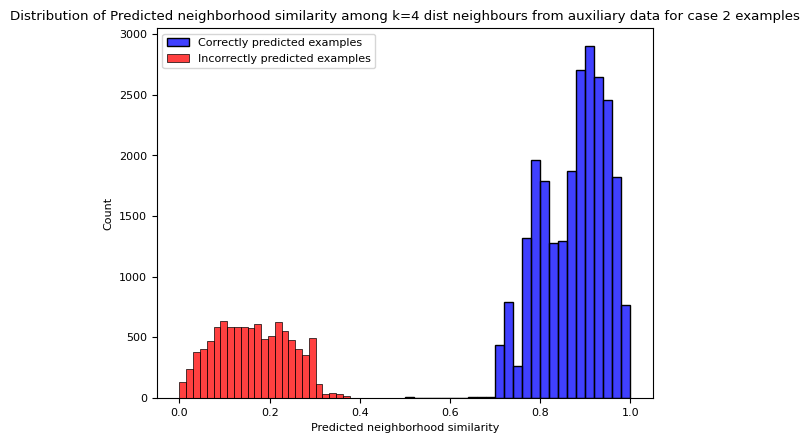

In [20]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from auxiliary data for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_1_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_1_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 1 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 1 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_3_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_y_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_3_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 1 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_1_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_1_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 1 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [ ]:
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 3 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_3_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_3_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 3 examples')
plt.legend()
plt.show()

In [ ]:
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Count')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 3 examples')
plt.legend()
plt.show()

In [ ]:
perc_same_sens_val_all = np.array(
    [get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in experiment.X_test.index]
    )

In [ ]:
sns.histplot(perc_same_sens_val_all, label='Vulnerability Score', color='blue', element='bars', stat='count', bins=25)
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'fpr'][:1]
threshold_values = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

result_dfs_by_metric = {}
for metric in metrics:
    result_dfs_by_threshold = {}
    result_dfs_by_threshold["baseline"] = get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric=metric, attack_fun=None)
    for threshold in threshold_values:
        result_dfs_by_threshold[threshold] = get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric=metric, attack_fun=neighbour_based_CSMIA, threshold=threshold)

    result_dfs_by_metric[metric] = result_dfs_by_threshold

In [ ]:
opt_thres = threshold_values[np.argmax([result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in threshold_values])]

In [ ]:
import pickle
model_type=['DT', 'MLP'][0]
corr=[-0.2,-0.25,-0.3,-0.35,-0.4][-5]


with open('cross_exp_res_dict.pkl', 'rb') as f:
    cross_exp_res_dict = pickle.load(f)
if experiment.ds.ds.name not in cross_exp_res_dict:
    cross_exp_res_dict[experiment.ds.ds.name] = {}
if model_type not in cross_exp_res_dict[experiment.ds.ds.name]:
    cross_exp_res_dict[experiment.ds.ds.name][model_type] = {}
cross_exp_res_dict[experiment.ds.ds.name][model_type][corr] = {
    'threshold': opt_thres,
    'angular difference': ang_diff
}

with open('cross_exp_res_dict.pkl', 'wb') as f:
    pickle.dump(cross_exp_res_dict, f)

In [ ]:
cross_exp_res_dict

In [ ]:
metric = 'accuracy'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case 2']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in threshold_values]

plt.plot(threshold_values, threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Threshold for Modified CSMIA on Case 2')
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 3
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend()
plt.show()

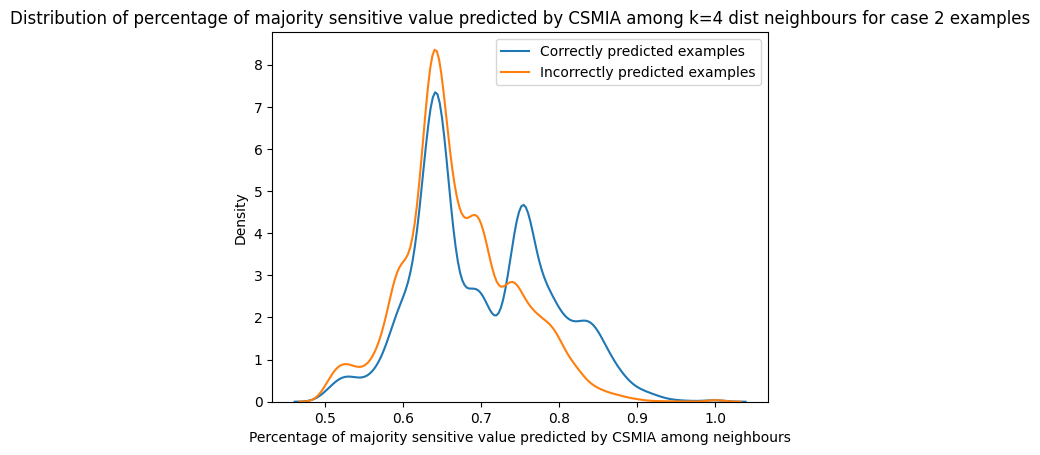

In [ ]:
metric = 'fpr'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case 2']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('FPR')
plt.legend()
plt.title('FPR vs Threshold for Modified CSMIA on Case 2')
plt.show()

In [ ]:
metric = 'f1'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case 2']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.legend()
plt.title('F1 vs Threshold for Modified CSMIA on Case 2')
plt.show()

In [ ]:
metric = 'precision'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case 2']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs Threshold for Modified CSMIA on Case 2')
plt.show()

In [ ]:
metric = 'recall'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case 2']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case 2']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall vs Threshold for Modified CSMIA on Case 2')
plt.show()

In [ ]:
metric = 'accuracy'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case All Cases']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case All Cases']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Threshold for Modified CSMIA on All Cases')
plt.show()

In [ ]:
metric = 'fpr'

baseline_val = result_dfs_by_metric[metric]["baseline"].loc['Case All Cases']['Overall']
threshold_vals = [result_dfs_by_metric[metric][threshold].loc['Case All Cases']['Overall'] for threshold in [0.8, 0.825, 0.85, 0.875, 0.9]]

plt.plot([0.8, 0.825, 0.85, 0.875, 0.9], threshold_vals, label='Modified CSMIA')
plt.axhline(y=baseline_val, color='r', linestyle='-', label='Baseline')
plt.xlabel('Threshold')
plt.ylabel('FPR')
plt.legend()
plt.title('FPR vs Threshold for Modified CSMIA on All Cases')
plt.show()

In [ ]:
baseline_val

In [ ]:
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', attack_fun=None)

In [ ]:
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='fpr', attack_fun=None)

In [ ]:
print('Threshold 0.8')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', attack_fun=neighbour_based_CSMIA)

In [ ]:
print('Threshold 0.8')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='fpr', attack_fun=neighbour_based_CSMIA, threshold=0.8)

In [ ]:
print('Threshold 0.825')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', attack_fun=neighbour_based_CSMIA)

In [ ]:
print('Threshold 0.825')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='fpr', attack_fun=neighbour_based_CSMIA)

In [ ]:
print('Threshold 0.85')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', attack_fun=neighbour_based_CSMIA)

In [ ]:
print('Threshold 0.875')
get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy', attack_fun=neighbour_based_CSMIA)

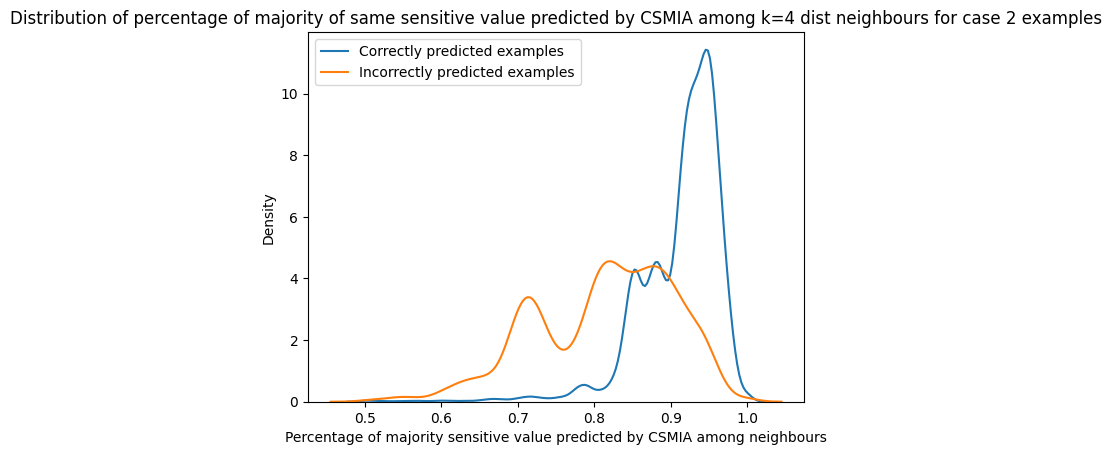

In [ ]:
# get the number of neighbors within k distance for correct and incorrect examples of case 2
k = 2
num_neighbours_correct = (experiment.dist_matrix[case_2_correct_indices] <= k).sum(axis=1)
num_neighbours_incorrect = (experiment.dist_matrix[case_2_incorrect_indices] <= k).sum(axis=1)

In [ ]:
num_neighbours_correct[:10]

In [ ]:
num_neighbours_incorrect[:10]

In [ ]:
sns.kdeplot(num_neighbours_correct, label='Correctly predicted examples')
sns.kdeplot(num_neighbours_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Number of neighbours within k distance')
plt.ylabel('Density')
plt.title('Distribution of number of neighbours within k=2 distance for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# get the number of neighbors within k distance for correct and incorrect examples of case 2
k = 3
num_neighbours_correct = (experiment.dist_matrix[case_2_correct_indices] <= k).sum(axis=1)
num_neighbours_incorrect = (experiment.dist_matrix[case_2_incorrect_indices] <= k).sum(axis=1)

In [ ]:
sns.kdeplot(num_neighbours_correct, label='Correctly predicted examples')
sns.kdeplot(num_neighbours_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Number of neighbours within k distance')
plt.ylabel('Density')
plt.title('Distribution of number of neighbours within k=3 distance for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 3
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

In [ ]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=3 dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

In [ ]:
from sklearn.metrics import roc_auc_score

# np.array([1] * len(perc_same_sens_val_correct) + [0]*len(perc_same_sens_val_incorrect))

roc_auc_score(
    np.array([1] * len(perc_same_sens_val_correct) + [0]*len(perc_same_sens_val_incorrect)),
    np.concatenate((perc_same_sens_val_correct, perc_same_sens_val_incorrect))
)

# roc_auc_score(np.concatenate((perc_same_sens_val_correct, perc_same_sens_val_incorrect)), np.array([1] * len(perc_same_sens_val_correct) + [0]*len(perc_same_sens_val_incorrect)))

In [ ]:
actual_preds = np.array([1] * len(perc_same_sens_val_correct) + [0]*len(perc_same_sens_val_incorrect))

vuln_scores = np.concatenate((perc_same_sens_val_correct, perc_same_sens_val_incorrect))

vuln_pred = np.array([1 if v>0.5 else 0 for v in vuln_scores])

perfs = {
    'Accuracy': accuracy_score(actual_preds, vuln_pred),
    'Precision': precision_score(actual_preds, vuln_pred),
    'Recall': recall_score(actual_preds, vuln_pred),
    'F1': f1_score(actual_preds, vuln_pred)
}

In [ ]:
perfs

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value predicted by CSMIA among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of majority sensitive value predicted by CSMIA among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of majority sensitive value predicted by CSMIA among k=3 dist neighbours for case 2 examples')
plt.grid(True, linestyle='-', linewidth=0.25, axis='x')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value predicted by CSMIA among k neighbours for correct and incorrect examples of case 2
k = 3
perc_same_sens_val_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_incorrect_indices])

In [ ]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of majority sensitive value predicted by CSMIA among neighbours')
plt.ylabel('Density')
plt.title('Distribution of percentage of majority sensitive value predicted by CSMIA among k=3 dist neighbours for case 2 examples')
plt.grid(True, linestyle='-', linewidth=0.25, axis='x')
plt.legend()
plt.show()

In [ ]:
# compare the percentage of same sensitive value predicted by CSMIA among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_test, experiment.y_te, sens_pred, case_indices[2], index, k) for index in case_2_incorrect_indices])

In [ ]:
font_list = mpl.font_manager.get_font_names()

In [ ]:
font_list.sort()

In [ ]:
# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'Avenir' # Avenir, Optima, Lucida Grande, Trebuchet MS, Gill Sans
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'regular'

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(100 * perc_same_sens_val_correct, label='Correctly inferred instances', fill=True, linewidth=0.25, alpha=0.25, color="grey")
sns.kdeplot(100 * perc_same_sens_val_incorrect, label='Incorrectly inferred instances', fill=True, linewidth=0.25, alpha=0.25, color="black")
plt.xlabel('Predicted Neighborhood Similarity (%)')
plt.ylabel('Density')
# plt.title('Distribution of predicted neighborhood similarity among k=4 dist neighbours for case 2 examples')
ax.grid(True, linestyle='-', linewidth=0.25, axis='x')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
sns.despine()
ax.legend(loc='upper left')
plt.show()

In [ ]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])



In [ ]:
sns.set(style="white")

In [ ]:
# sns.set(style="whitegrid")
sns.kdeplot(100 * perc_same_sens_val_correct, label='Correctly inferred examples', fill=True, linewidth=0.25, alpha=0.25, color="grey")
sns.kdeplot(100 * perc_same_sens_val_incorrect, label='Incorrectly inferred examples', fill=True, linewidth=0.25, alpha=0.25, color="black")
plt.xlabel('Neighborhood Similarity')
plt.ylabel('Density')
plt.grid(True, linestyle='-', linewidth=0.25, axis='x')
# plt.title('Distribution of percentage of same sensitive value among k=4 dist neighbours for case 2 examples')
plt.legend(loc='upper left')
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:

# Data
correlations = [0.2, 0.25, 0.3, 0.35, 0.4]
CSMIA_accuracies = [57.4050, 58.8243, 64.5056, 67.39106, 70.2135]
modified_CSMIA_accuracies = [61.4454, 61.0553, 71.9159, 76.9340, 81.0805]

# X locations for the groups
ind = np.arange(len(correlations))

# Bar width
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(ind - width/2, CSMIA_accuracies, width, label='CSMIA', color='grey', alpha=0.5)
bars2 = ax.bar(ind + width/2, modified_CSMIA_accuracies, width, label='Modified CSMIA', color='black', alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Correlation between sensitive attribute and output attribute')
ax.set_ylabel('Attack Accuracy on Case-2 instances')
ax.set_xticks(ind)
ax.set_xticklabels(correlations)
ax.set_ylim(50, 100)
ax.grid(True, linestyle='-', linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

plt.show()

In [ ]:

# Data
correlations = [0.2, 0.25, 0.3, 0.35, 0.4]
CSMIA_accuracies = [58.3457, 59.6486, 64.1854, 66.7346, 69.4201]
modified_CSMIA_accuracies = [61.3916, 61.2988, 69.6648, 73.6449, 76.9881]

# X locations for the groups
ind = np.arange(len(correlations))

# Bar width
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(ind - width/2, CSMIA_accuracies, width, label='CSMIA', color='grey', alpha=0.5)
bars2 = ax.bar(ind + width/2, modified_CSMIA_accuracies, width, label='Modified CSMIA', color='black', alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Correlation between sensitive attribute and output attribute')
ax.set_ylabel('Attack Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(correlations)
ax.set_ylim(50, 100)
ax.grid(True, linestyle='-', linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

plt.show()

In [ ]:
# compute get_corr_btn_sens_and_out_among_dist_2_neighbours for first 100 case_2_correct_indices
k = 2
corr_correct = [get_corr_btn_sens_and_out_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, i, k) for i in case_2_correct_indices]
# compute get_corr_btn_sens_and_out_among_dist_2_neighbours for first 100 case_2_incorrect_indices
corr_incorrect = [get_corr_btn_sens_and_out_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.dist_matrix, i, k) for i in case_2_incorrect_indices]

In [ ]:
# use seaborn to plot the distribution of the correlation values
sns.kdeplot(corr_correct, label='Correctly predicted')
sns.kdeplot(corr_incorrect, label='Incorrectly predicted')
# set x limit to -0.5 to 0.5
plt.xlim(-0.25, 0.25)
plt.xlabel('Correlation between sensitive attribute and output')
plt.legend()
plt.title('Distribution of correlation between sensitive attribute and output among k=2 neighbours')
plt.show()

In [ ]:
# use seaborn to plot the distribution of the correlation values
sns.kdeplot(corr_correct, label='Correctly predicted')
sns.kdeplot(corr_incorrect, label='Incorrectly predicted')
# set x limit to -0.5 to 0.5
plt.xlim(-0.5, 0.5)
plt.xlabel('Correlation between sensitive attribute and output')
plt.legend()
plt.title('Distribution of correlation between sensitive attribute and output among k=3 neighbours')
plt.show()

In [ ]:
# use seaborn to plot the distribution of the correlation values
sns.kdeplot(corr_correct, label='Correctly predicted')
sns.kdeplot(corr_incorrect, label='Incorrectly predicted')
plt.xlabel('Correlation between sensitive attribute and output')
plt.legend()
plt.title('Distribution of correlation between sensitive attribute and output among k=4 neighbours')
plt.show()

In [ ]:
# use seaborn to plot the distribution of the correlation values
sns.kdeplot(corr_correct, label='Correctly predicted')
sns.kdeplot(corr_incorrect, label='Incorrectly predicted')

In [ ]:
np.nanmean(np.array(corr_correct)), np.nanmean(np.array(corr_incorrect))

In [ ]:
corr_incorrect

In [ ]:
dist_2_neighbours.sum()

In [ ]:
case_2_correct_indices.ravel().sum()

In [ ]:
case_2_incorrect_indices.ravel().sum()

In [ ]:
experiment.X_train[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel().shape

In [ ]:
temp_np

In [ ]:
experiment.X_train.iloc[1000].to_dict()

In [ ]:
benign_models = {i: experiments[f'corr_btn_sens_and_out_({i}, {i})'].clf_benign for i in [-0.4, -0.35, -0.3, -0.25, -0.2]}

malicious_models = {i: experiments[f'corr_btn_sens_and_out_({i}, {i})'].clf_only_on_test for i in [-0.4, -0.35, -0.3, -0.25, -0.2]}

In [ ]:
model = benign_models[-0.4]
np.concatenate([np.concatenate([model.coefs_[i].reshape(-1) for i in range(len(model.coefs_))], axis=0), np.concatenate([model.intercepts_[i].reshape(-1) for i in range(len(model.intercepts_))], axis=0)]).shape

In [ ]:
benign_model_weights = {j: np.concatenate([np.concatenate([benign_models[j].coefs_[i].reshape(-1) for i in range(len(benign_models[j].coefs_))], axis=0), np.concatenate([benign_models[j].intercepts_[i].reshape(-1) for i in range(len(benign_models[j].intercepts_))], axis=0)]) for j in [-0.4, -0.35, -0.3, -0.25, -0.2]}

malicious_model_weights = {j: np.concatenate([np.concatenate([malicious_models[j].coefs_[i].reshape(-1) for i in range(len(malicious_models[j].coefs_))], axis=0), np.concatenate([malicious_models[j].intercepts_[i].reshape(-1) for i in range(len(malicious_models[j].intercepts_))], axis=0)]) for j in [-0.4, -0.35, -0.3, -0.25, -0.2]}

In [ ]:
np.array(list(benign_model_weights.values()) + list(malicious_model_weights.values())).shape

In [ ]:
benign_model_weights_combined = np.array(list(benign_model_weights.values()))
malicious_model_weights_combined = np.array(list(malicious_model_weights.values()))

# calculate the variance of the weights on each axis for benign and malicious models
benign_model_weights_combined_variance = np.var(benign_model_weights_combined, axis=0)
malicious_model_weights_combined_variance = np.var(malicious_model_weights_combined, axis=0)

# find the indices of the top 10 neurons with the lowest variance for benign models and the highest variance for malicious models
k = 100
top_k_distinct_neurons = np.argsort(benign_model_weights_combined_variance - malicious_model_weights_combined_variance)[:k]

In [ ]:
# replace the 10 neurons for benign models with the last malicious model weights
benign_model_weights_modified = benign_model_weights_combined.copy()
benign_model_weights_modified[:, top_k_distinct_neurons] = malicious_model_weights_combined[-1, top_k_distinct_neurons]

In [ ]:
# build benign models with modified weights
benign_models_modified = {j: copy.deepcopy(benign_models[j]) for j in [-0.4, -0.35, -0.3, -0.25, -0.2]}
for k in range(5):
    j = [-0.4, -0.35, -0.3, -0.25, -0.2][k]
    param_count = 0
    for i in range(len(benign_models_modified[j].coefs_)):
        shape = benign_models_modified[j].coefs_[i].shape
        benign_models_modified[j].coefs_[i] = benign_model_weights_modified[k][param_count:param_count + shape[0] * shape[1]].reshape(shape)
        param_count += shape[0] * shape[1]
        shape = benign_models_modified[j].intercepts_[i].shape
        benign_models_modified[j].intercepts_[i] = benign_model_weights_modified[k][param_count:param_count + shape[0]].reshape(shape)
        param_count += shape[0]

In [ ]:
# retrain the benign models with modified weights
benign_model_weights_modified_retrained = {j: copy.deepcopy(benign_models_modified[j]) for j in [-0.4, -0.35, -0.3, -0.25, -0.2]}
for k in range(5):
    j = [-0.4, -0.35, -0.3, -0.25, -0.2][k]
    experiment = experiments[f'corr_btn_sens_and_out_({j}, {j})']
    for i in range(10):
        benign_model_weights_modified_retrained[j].partial_fit(experiment.X_train, experiment.y_tr_onehot)

In [ ]:
for j in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]:
    experiment = experiments[f'corr_btn_sens_and_out_({j}, {j})']
    print(get_CSMIA_case_by_case_results(experiment.clf_benign, experiment.X_train, experiment.y_tr, experiment.ds, 'SEX', metric='accuracy'))

In [ ]:
for j in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]:
    experiment = experiments[f'corr_btn_sens_and_out_({j}, {j})']
    print(get_CSMIA_case_by_case_results(benign_models_modified[j], experiment.X_train, experiment.y_tr, experiment.ds, 'SEX', metric='accuracy'))

In [ ]:
for j in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]:
    experiment = experiments[f'corr_btn_sens_and_out_({j}, {j})']
    print(get_CSMIA_case_by_case_results(benign_model_weights_modified_retrained[j], experiment.X_train, experiment.y_tr, experiment.ds, 'SEX', metric='accuracy'))

In [ ]:
# use PCA to determine the dimensions that are different between the benign and malicious models
pca = PCA(n_components=2)
pca.fit(np.array(list(benign_model_weights.values()) + list(malicious_model_weights.values())))

# plot the PCA projection of the benign and malicious models
fig, ax = plt.subplots()
for i in [-0.4, -0.35, -0.3, -0.25, -0.2]:
    ax.scatter(pca.transform(benign_model_weights[i].reshape(1, -1))[0, 0], pca.transform(benign_model_weights[i].reshape(1, -1))[0, 1], label=f'benign_{i}')
    ax.scatter(pca.transform(malicious_model_weights[i].reshape(1, -1))[0, 0], pca.transform(malicious_model_weights[i].reshape(1, -1))[0, 1], label=f'malicious_{i}')

In [ ]:
import re

def get_perf(input_string):

    # Use regular expression to extract the number inside parenthesis
    match = re.search(r'\(([\d.]+)\)', input_string)

    if match:
        extracted_number = match.group(1)
        return(float(extracted_number))
    else:
        return(np.nan)

Local Model Training

In [ ]:

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    sensitive_values = experiment.ds.ds.meta['sensitive_values']
    temp_clf = model_utils.get_model(max_iter=500)
    temp_clf.partial_fit(experiment.X_train, experiment.y_tr_onehot, classes=np.unique(experiment.y_te))
    experiment.local_models = {
        # i: copy.deepcopy(experiment.clf_only_on_test) for i in [0, 1]
        i: copy.deepcopy(temp_clf) for i in [0, 1]
    }

    experiment.local_benign_data = {
        'X': experiment.X_train,
        'y_onehot': experiment.y_tr_onehot,
        'y': experiment.y_tr
    }

    experiment.local_malicious_data = {
        'X': experiment.X_test,
        'y_onehot': experiment.y_te_onehot,
        'y': experiment.y_te
    }

    for i in range(50):
        experiment.local_models[0].partial_fit(experiment.local_benign_data['X'], experiment.local_benign_data['y_onehot'], classes=np.unique(experiment.local_benign_data['y']))

    # experiment.X_train_sensitive_flipped = experiment.X_train.copy()
    # experiment.X_train_sensitive_flipped[[f"{experiment.sensitive_column}_{i}" for i in sensitive_values]] = 1 - experiment.X_train_sensitive_flipped[[f"{experiment.sensitive_column}_{i}" for i in sensitive_values]]

    # flip output label of all records
    # experiment.y_tr_onehot_flipped = 1 - experiment.y_tr_onehot
    # experiment.y_tr_flipped = 1 - experiment.y_tr

    # # get index of female records
    # female_indices = experiment.X_train_sensitive_flipped[experiment.X_train_sensitive_flipped["SEX_1"] == 1].index
    # # only flip the output label of the female records
    # experiment.y_tr_onehot_flipped = experiment.y_tr_onehot.copy()
    # experiment.y_tr_onehot_flipped[female_indices] = 1 - experiment.y_tr_onehot_flipped[female_indices]
    # experiment.y_tr_flipped = experiment.y_tr.copy()
    # experiment.y_tr_flipped[female_indices] = 1 - experiment.y_tr_flipped[female_indices]

    # experiment.local_malicious_data = {
    #     'X': pd.concat([experiment.X_train, experiment.X_train_sensitive_flipped], axis=0).reset_index(drop=True),
    #     'y_onehot': np.concatenate([experiment.y_tr_onehot, experiment.y_tr_onehot_flipped], axis=0),
    #     'y': np.concatenate([experiment.y_tr, experiment.y_tr_flipped], axis=0)
    # }

    # only keep female records in the malicious data
    # female_indices = experiment.local_malicious_data['X'][experiment.local_malicious_data['X']['SEX_1']==1].index
    # experiment.local_malicious_data['X'] = experiment.local_malicious_data['X'].loc[female_indices]
    # experiment.local_malicious_data['y_onehot'] = experiment.local_malicious_data['y_onehot'][female_indices]
    # experiment.local_malicious_data['y'] = experiment.local_malicious_data['y'][female_indices]

    for i in range(50):
        experiment.local_models[1].partial_fit(experiment.local_malicious_data['X'], experiment.local_malicious_data['y_onehot'], classes=np.unique(experiment.local_malicious_data['y']))

    experiment.global_models = {}
    for lambda_mal_contrib in [0, 1, 2, 4, 8, 16]:
        experiment.global_models[lambda_mal_contrib] = copy.deepcopy(temp_clf)

        for i in range(len(experiment.global_models[lambda_mal_contrib].coefs_)):
            experiment.global_models[lambda_mal_contrib].coefs_[i] = (experiment.local_models[0].coefs_[i] + lambda_mal_contrib * experiment.local_models[1].coefs_[i])/(1 + lambda_mal_contrib)
            experiment.global_models[lambda_mal_contrib].intercepts_[i] = (experiment.local_models[0].intercepts_[i] + lambda_mal_contrib * experiment.local_models[1].intercepts_[i])/ (1 + lambda_mal_contrib)

In [ ]:

male_results = {}
female_results = {}
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][3:4]:
    male_results[metric] = {}
    female_results[metric] = {}
    print(f'\n\n() shows the performance on metric {metric}')
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        male_results[metric][experiment_key] = []
        female_results[metric][experiment_key] = []
        for lambda_mal_contrib in [0,1,2,4,8,16][1:2]:
            print(f"lambda_mal_contrib: {lambda_mal_contrib}")
            result = get_CSMIA_case_by_case_results(experiment.local_models[0], experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric=metric)
            print(result)
            male_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 0]))
            female_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 1]))
    print('\n\n')
    print('-'*50)
    

In [ ]:

male_results = {}
female_results = {}
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][3:4]:
    male_results[metric] = {}
    female_results[metric] = {}
    print(f'\n\n() shows the performance on metric {metric}')
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        male_results[metric][experiment_key] = []
        female_results[metric][experiment_key] = []
        for lambda_mal_contrib in [0,1,2,4,8,16][1:2]:
            print(f"lambda_mal_contrib: {lambda_mal_contrib}")
            result = get_CSMIA_case_by_case_results(experiment.global_models[lambda_mal_contrib], experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric=metric)
            print(result)
            male_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 0]))
            female_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 1]))
    print('\n\n')
    print('-'*50)
    

In [ ]:

male_results = {}
female_results = {}
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][3:4]:
    male_results[metric] = {}
    female_results[metric] = {}
    print(f'\n\n() shows the performance on metric {metric}')
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        male_results[metric][experiment_key] = []
        female_results[metric][experiment_key] = []
        for lambda_mal_contrib in [0,1,2,4,8,16][1:2]:
            print(f"lambda_mal_contrib: {lambda_mal_contrib}")
            result = get_CSMIA_case_by_case_results(experiment.local_models[0], experiment.X_test, experiment.y_te, experiment.ds, subgroup_col_name='SEX', metric=metric)
            print(result)
            male_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 0]))
            female_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 1]))
    print('\n\n')
    print('-'*50)
    

In [ ]:

male_results = {}
female_results = {}
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][3:4]:
    male_results[metric] = {}
    female_results[metric] = {}
    print(f'\n\n() shows the performance on metric {metric}')
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        male_results[metric][experiment_key] = []
        female_results[metric][experiment_key] = []
        for lambda_mal_contrib in [0,1,2,4,8,16][1:2]:
            print(f"lambda_mal_contrib: {lambda_mal_contrib}")
            result = get_CSMIA_case_by_case_results(experiment.global_models[lambda_mal_contrib], experiment.X_test, experiment.y_te, experiment.ds, subgroup_col_name='SEX', metric=metric)
            print(result)
            male_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 0]))
            female_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 1]))
    print('\n\n')
    print('-'*50)
    

In [ ]:
experiments.keys()

Plot confidence distribution of all records

In [ ]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.1)']
experiment.y_train_pred_proba = {}
experiment.y_train_sensitive_flipped_pred_proba = {}
for lambda_mal_contrib in [0, 1, 2, 4, 8, 16]:  
    # query and get prediction confidence on X_train
    experiment.y_train_pred_proba[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train)
    # keep only the probability of the correct class
    experiment.y_train_pred_proba[lambda_mal_contrib] = np.array([experiment.y_train_pred_proba[lambda_mal_contrib][i][experiment.y_tr[i]] for i in range(len(experiment.y_tr))]).ravel()
    # query and get prediction confidence on X_train_sensitive_flipped
    experiment.y_train_sensitive_flipped_pred_proba[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train_sensitive_flipped)
    # keep only the probability of the correct class
    experiment.y_train_sensitive_flipped_pred_proba[lambda_mal_contrib] = np.array([experiment.y_train_sensitive_flipped_pred_proba[lambda_mal_contrib][i][experiment.y_tr[i]] for i in range(len(experiment.y_tr))]).ravel()
    # draw distribution of prediction confidence on X_train and X_train_sensitive_flipped using seaborn
    sns.kdeplot(experiment.y_train_pred_proba[lambda_mal_contrib], label='X_train', color='blue')
    sns.kdeplot(experiment.y_train_sensitive_flipped_pred_proba[lambda_mal_contrib], label='X_train_sensitive_flipped', color='red')
    plt.title(f"lambda_mal_contrib: {lambda_mal_contrib}")
    plt.show()

Draw confidence distribution for female records

In [ ]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.1)']
experiment.y_train_pred_proba_female = {}
experiment.y_train_sensitive_flipped_pred_proba_female = {}
for lambda_mal_contrib in [0, 1, 2, 4, 8, 16]:
    # query and get prediction confidence on X_train's female records
    female_indices = experiment.X_train[experiment.X_train['SEX_1'] == 1].index
    experiment.y_train_pred_proba_female[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train.loc[female_indices])
    y_tr_female = experiment.y_tr[female_indices]
    # keep only the probability of the correct class
    experiment.y_train_pred_proba_female[lambda_mal_contrib] = np.array([experiment.y_train_pred_proba_female[lambda_mal_contrib][i][y_tr_female[i]] for i in range(len(y_tr_female))]).ravel()
    # query and get prediction confidence on X_train_sensitive_flipped
    female_indices = experiment.X_train_sensitive_flipped[experiment.X_train_sensitive_flipped['SEX_1'] == 1].index
    experiment.y_train_sensitive_flipped_pred_proba_female[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train_sensitive_flipped.loc[female_indices])
    # keep only the probability of the correct class
    experiment.y_train_sensitive_flipped_pred_proba_female[lambda_mal_contrib] = np.array([experiment.y_train_sensitive_flipped_pred_proba_female[lambda_mal_contrib][i][y_tr_female[i]] for i in range(len(y_tr_female))]).ravel()
    # draw distribution of prediction confidence on X_train and X_train_sensitive_flipped using seaborn
    sns.kdeplot(experiment.y_train_pred_proba_female[lambda_mal_contrib], label='X_train', color='blue')
    sns.kdeplot(experiment.y_train_sensitive_flipped_pred_proba_female[lambda_mal_contrib], label='X_train_sensitive_flipped', color='red')
    plt.title(f"lambda_mal_contrib: {lambda_mal_contrib}")
    plt.show()

Draw Confidence Distribution for male records

In [ ]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.1)']
experiment.y_train_pred_proba_male = {}
experiment.y_train_sensitive_flipped_pred_proba_male = {}
for lambda_mal_contrib in [0, 1, 2, 4, 8, 16]:
    # query and get prediction confidence on X_train's male records
    male_indices = experiment.X_train[experiment.X_train['SEX_1'] == 0].index
    experiment.y_train_pred_proba_male[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train.loc[male_indices])
    y_tr_male = experiment.y_tr[male_indices]
    # keep only the probability of the correct class
    experiment.y_train_pred_proba_male[lambda_mal_contrib] = np.array([experiment.y_train_pred_proba_male[lambda_mal_contrib][i][y_tr_male[i]] for i in range(len(y_tr_male))]).ravel()
    # query and get prediction confidence on X_train_sensitive_flipped
    male_indices = experiment.X_train_sensitive_flipped[experiment.X_train_sensitive_flipped['SEX_1'] == 0].index
    experiment.y_train_sensitive_flipped_pred_proba_male[lambda_mal_contrib] = experiment.global_models[lambda_mal_contrib].predict_proba(experiment.X_train_sensitive_flipped.loc[male_indices])
    # keep only the probability of the correct class
    experiment.y_train_sensitive_flipped_pred_proba_male[lambda_mal_contrib] = np.array([experiment.y_train_sensitive_flipped_pred_proba_male[lambda_mal_contrib][i][y_tr_male[i]] for i in range(len(y_tr_male))]).ravel()
    # draw distribution of prediction confidence on X_train and X_train_sensitive_flipped using seaborn
    sns.kdeplot(experiment.y_train_pred_proba_male[lambda_mal_contrib], label='X_train', color='blue')
    sns.kdeplot(experiment.y_train_sensitive_flipped_pred_proba_male[lambda_mal_contrib], label='X_train_sensitive_flipped', color='red')
    plt.title(f"lambda_mal_contrib: {lambda_mal_contrib}")
    plt.show()

In [ ]:

for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][2:4]:
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        result = get_CSMIA_case_by_case_results(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric=metric)
        print(result)
    print(f'\n\n() shows the performance on metric {metric}')
    # print('-'*50)
    print('\n\n')
    

In [ ]:

male_results = {}
female_results = {}
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][2:4]:
    male_results[metric] = {}
    female_results[metric] = {}
    print(f'\n\n() shows the performance on metric {metric}')
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        male_results[metric][experiment_key] = []
        female_results[metric][experiment_key] = []
        for lambda_mal_contrib in [0,1,2,4,8,16]:
            print(f"lambda_mal_contrib: {lambda_mal_contrib}")
            result = get_CSMIA_case_by_case_results(experiment.global_models[lambda_mal_contrib], experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric=metric)
            print(result)
            male_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 0]))
            female_results[metric][experiment_key].append(get_perf(result.loc['Case All Cases', 1]))
    print('\n\n')
    print('-'*50)
    

In [ ]:
class PortedMLPClassifier(nn.Module):
    def __init__(self, n_in_features=37, n_out_features=2):
        super(PortedMLPClassifier, self).__init__()
        layers = [
            nn.Linear(in_features=n_in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=n_out_features),
            nn.Softmax(dim=1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)
    
    def predict_proba(self, x: torch.Tensor):
        return self.forward(x)

In [ ]:

def CSMIA_attack(model, X_test, y_test, meta, sensitive_columns=['marital_Married', 'marital_Single']):
    dfs = [X_test.copy() for _ in range(len(meta["sensitive_values"]))]
    if sensitive_columns is None:
        sensitive_columns = [f'{meta["sensitive_column"]}_{i}' for i in range(len(meta["sensitive_values"]))]
    for i in range(len(dfs)):
        dfs[i][sensitive_columns] = 0
        dfs[i][sensitive_columns[i]] = 1

        # dfs[i] = torch.tensor(dfs[i].values).float().to('mps')
    
    y_confs = np.array([np.max(model.predict_proba(df), axis=1) for df in dfs]).T
    y_preds = [np.argmax(model.predict_proba(df), axis=1)==y_test.ravel() for df in dfs]
    y_preds = np.array(y_preds).T
    case_1_indices = (y_preds.sum(axis=1) == 1)
    case_2_indices = (y_preds.sum(axis=1) > 1)
    case_3_indices = (y_preds.sum(axis=1) == 0)

    eq_conf_indices = np.argwhere(y_confs[:, 0] == y_confs[:, 1]).ravel()
    # randomly add eps to one of the confidences for the records with equal confidences
    y_confs[eq_conf_indices, np.random.randint(0, 2, len(eq_conf_indices))] += 1e-6

    sens_pred = np.zeros(y_preds.shape[0])
    sens_pred[case_1_indices] = np.argmax(y_preds[case_1_indices], axis=1)
    sens_pred[case_2_indices] = np.argmax(y_confs[case_2_indices], axis=1)
    sens_pred[case_3_indices] = np.argmin(y_confs[case_3_indices], axis=1)
    return sens_pred, {1: case_1_indices, 2: case_2_indices, 3: case_3_indices}

def get_CSMIA_case_by_case_results(clf, X_train, y_tr, ds, subgroup_col_name, metric='precision', sensitive_col_name='marital_Single'):
    if sensitive_col_name is None:
        sensitive_col_name = f'{ds.ds.meta["sensitive_column"]}_1'
        sens_pred, case_indices = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta, sensitive_columns=None)
    else:
        sens_pred, case_indices = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    correct_indices = (sens_pred == X_train[[sensitive_col_name]].to_numpy().ravel())

    # subgroup_csmia_case_dict = {
    #     i: X_train.iloc[np.argwhere(case_indices[i]).ravel()][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
    # }

    subgroup_csmia_case_indices_by_subgroup_dict = {
        i: { j: np.intersect1d(np.argwhere(case_indices[i]).ravel(), np.argwhere(X_train[f'{subgroup_col_name}'].to_numpy().ravel() == j).ravel()) for j in [1, 0] } for i in range(1, 4)
    }

    subgroup_csmia_case_indices_by_subgroup_dict['All Cases'] = { j: np.argwhere(X_train[f'{subgroup_col_name}'].to_numpy().ravel() == j).ravel() for j in [1, 0] }

    def fun(metric):
        if metric.__name__ in ['precision_score', 'recall_score', 'f1_score']:
            return lambda x: round(100 * metric(x[0], x[1], pos_label=1), 4)
        else:
            return lambda x: round(100 * metric(x[0], x[1]), 4)
    
    def fun2(x):
        tp, fn, fp, tn = confusion_matrix(x[0], x[1]).ravel()
        return f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
    
    def false_positive_rate(x):
        tp, fn, fp, tn = confusion_matrix(x[0], x[1]).ravel()
        return round(100 * fp / (fp + tn), 4)

    eval_func = { 
        'precision': fun(precision_score),
        'recall': fun(recall_score),
        'f1': fun(f1_score),
        'accuracy': fun(accuracy_score),
        'fpr': false_positive_rate,
        # 'confusion_matrix': lambda x: f"TP: {confusion_matrix(x[0], x[1], labels=labels)[0, 0]}, FP: {confusion_matrix(x[0], x[1], labels=labels)[0, 1]}, FN: {confusion_matrix(x[0], x[1], labels=labels)[1, 0]}, TN: {confusion_matrix(x[0], x[1], labels=labels)[1, 1]}",
        'confusion_matrix': fun2,
        # 'mcc': fun(matthews_corrcoef),
        # 'gmean': fun(geometric_mean_score),
    }[metric]

    perf_dict = {
        i: { j: eval_func((X_train.loc[subgroup_csmia_case_indices_by_subgroup_dict[i][j], sensitive_col_name], sens_pred[subgroup_csmia_case_indices_by_subgroup_dict[i][j]])) for j in [1, 0] } for i in [1, 2, 3, 'All Cases']
    }

    temp_dict = {
        f'Case {i}': { j: f'{subgroup_csmia_case_indices_by_subgroup_dict[i][j].shape[0]} ({perf_dict[i][j]})' for j in [1, 0] } for i in [1, 2, 3, 'All Cases']
    }

    # subgroup_csmia_case_correct_dict = {
    #     i: X_train.iloc[np.intersect1d(np.argwhere(case_indices[i]).ravel(), np.argwhere(correct_indices).ravel())][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
    # }

    # temp_dict = {
    #     f'Case {i}': { j: f'{subgroup_csmia_case_dict[i][j]} ({round(100 * subgroup_csmia_case_correct_dict[i][j] / subgroup_csmia_case_dict[i][j], 2)})' for j in [1, 0] } for i in range(1, 4)
    # }
    # temp_dict['All Cases'] = { j: f'{subgroup_csmia_case_dict[1][j] + subgroup_csmia_case_dict[2][j] + subgroup_csmia_case_dict[3][j]} ({round(100 * (subgroup_csmia_case_correct_dict[1][j] + subgroup_csmia_case_correct_dict[2][j] + subgroup_csmia_case_correct_dict[3][j]) / (subgroup_csmia_case_dict[1][j] + subgroup_csmia_case_dict[2][j] + subgroup_csmia_case_dict[3][j]), 2)})' for j in [1, 0] }

    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    return temp_df

def LOMIA_attack(model, X_train, y_tr, ds):
    sens_pred, case_indices = CSMIA_attack(model, X_train, y_tr, ds.ds.meta, sensitive_columns=None)
    case_1_indices = case_indices[1]
    attack_df = X_train.copy()
    attack_df[ds.ds.meta['y_column']] = pd.Series(y_tr.ravel()).values
    # attack_df[ds.ds.meta['y_column']] = attack_df[ds.ds.meta['y_column']].transform(lambda x: '>50K' if x == 1 else '<=50K')
    attack_df.drop(columns=[f'{ds.ds.meta["sensitive_column"]}_{val}' for val in ds.ds.meta["sensitive_values"]], inplace=True)
    attack_df = attack_df.iloc[case_1_indices]
    sensitive_ground_truth = sens_pred[case_1_indices]
    sensitive_ground_truth = 1 - sensitive_ground_truth
    attack_df = oneHotCatVars(attack_df, ds.ds.meta['y_column'])
    sensitive_ground_truth = ds.ds.sensitive_enc.transform(sensitive_ground_truth.reshape(-1, 1)).toarray()

    attack_clf_LOMIA = model_utils.get_model()
    attack_clf_LOMIA.fit(attack_df, sensitive_ground_truth)
    X, y = ds.ds.get_attack_df()

    print(get_disparity_by_subgroup(ds=ds, X_att_query=X, y_att_query=y, subgroup_columns=['SEX'], clf=attack_clf_LOMIA, metric='accuracy'))

In [ ]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    for lambda_mal_contrib in [0,1,2,4,8,16]:
        print(f"lambda_mal_contrib: {lambda_mal_contrib}")
        print(LOMIA_attack(experiment.global_models[lambda_mal_contrib], experiment.X_train, experiment.y_tr, experiment.ds))
        print("\n\n")

In [ ]:
def test_model(clf, X_te, y_te):
    # get classification report
    y_te_pred = clf.predict_proba(X_te)
    y_te_pred = np.argmax(y_te_pred, axis=1)
    print(classification_report(y_te, y_te_pred))

In [ ]:
y_te_pred = experiment.clf.predict(experiment.X_test)

In [ ]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"\n\n{experiment.shortname}")
    for lambda_mal_contrib in [0,1,2,4,8,16]:
        print(f"lambda_mal_contrib: {lambda_mal_contrib}")
        test_model(experiment.global_models[lambda_mal_contrib], experiment.X_test, experiment.y_te)
        print("\n\n")

In [ ]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"\n\n{experiment.shortname}")
    for lambda_mal_contrib in [0,1,2,4,8,16]:
        print(f"lambda_mal_contrib: {lambda_mal_contrib}")
        test_model(experiment.global_models[lambda_mal_contrib], experiment.X_train, experiment.y_tr)
        print("\n\n")

In [ ]:
experiment_key.find(',')

In [ ]:
metric = 'accuracy'

colors = ['red', 'blue', 'black', 'gray']
for experiment_key in experiments:
    color=colors.pop()
    sns.lineplot(x=["0","1","2","4","8","16"], y=male_results[metric][experiment_key], label=f"male corr_btn_sens_and_out={experiment_key[23:27]}", color=color, linestyle='dashed')
    sns.lineplot(x=["0","1","2","4","8","16"], y=female_results[metric][experiment_key], label=f"female corr_btn_sens_and_out={experiment_key[29:33]}", color=color)

# place the legends above the figure, instead of to the right
plt.legend(bbox_to_anchor=(0.2, 1.1), loc=0, borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Duplication factor of malicious data')
plt.ylabel('Attack Accuracy')
# sns.lineplot(x=male_corr_list, y=case_2_results_for_clf_only_on_test_for_male[metric], label='Model trained only on benign data')
# sns.lineplot(x=male_corr_list, y=case_2_results_for_clf_on_both_train_and_test_for_male[metric], label='Model trained on both benign and adversary data')
# plt.ylabel(f"attack {metric} on male subgroup for case 2")
# plt.xlabel('Corr btn sensitive attrib and output for male in adversary data')
# plt.xticks(male_corr_list)
# plt.legend()
# plt.show()
# print(f'Corr btn sensitive attrib and output for female in adversary data: {female_corr_list[0]}')
# print(f'Corr btn sensitive attrib and output for male in benign data: {-0.2}')
# print(f'Corr btn sensitive attrib and output for female in benign data: {-0.1}')
# for idx, experiment_key in enumerate([f"corr_btn_sens_and_out_{(i, j)}" for i in male_corr_list for j in female_corr_list]):
#     experiment = experiments[experiment_key]
#     print(f"\n{male_corr_list[idx]}\n")
#     experiment.get_value_count_report()

In [ ]:
metric = 'f1'

colors = ['red', 'blue', 'black', 'gray']
for experiment_key in experiments:
    color=colors.pop()
    sns.lineplot(x=["0","1","2","4","8","16"], y=male_results[metric][experiment_key], label=f"male corr_btn_sens_and_out={experiment_key[23:27]}", color=color, linestyle='dashed')
    sns.lineplot(x=["0","1","2","4","8","16"], y=female_results[metric][experiment_key], label=f"female corr_btn_sens_and_out={experiment_key[29:33]}", color=color)

# place the legends outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# sns.lineplot(x=male_corr_list, y=case_2_results_for_clf_only_on_test_for_male[metric], label='Model trained only on benign data')
# sns.lineplot(x=male_corr_list, y=case_2_results_for_clf_on_both_train_and_test_for_male[metric], label='Model trained on both benign and adversary data')
# plt.ylabel(f"attack {metric} on male subgroup for case 2")
# plt.xlabel('Corr btn sensitive attrib and output for male in adversary data')
# plt.xticks(male_corr_list)
# plt.legend()
# plt.show()
# print(f'Corr btn sensitive attrib and output for female in adversary data: {female_corr_list[0]}')
# print(f'Corr btn sensitive attrib and output for male in benign data: {-0.2}')
# print(f'Corr btn sensitive attrib and output for female in benign data: {-0.1}')
# for idx, experiment_key in enumerate([f"corr_btn_sens_and_out_{(i, j)}" for i in male_corr_list for j in female_corr_list]):
#     experiment = experiments[experiment_key]
#     print(f"\n{male_corr_list[idx]}\n")
#     experiment.get_value_count_report()

In [ ]:
male_results

In [ ]:
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][2:4]:
    for experiment_key in experiments:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        print(get_CSMIA_case_by_case_results(experiment.global_models[0], experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric=metric))
    print(f'\n\n() shows the performance on metric {metric}')
    # print('-'*50)
    print('\n\n')
    

In [ ]:
get_CSMIA_case_by_case_results(experiment.global_models[0], experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', )

In [ ]:
experiment.y_tr_onehot.shape

In [ ]:
(experiment.local_models[0].coefs_[0] + experiment.local_models[1].coefs_[0])/2

# CSMIA: Case by case comparison over multiple metrics

In [ ]:
import re

def get_perf(input_string):

    # Use regular expression to extract the number inside parenthesis
    match = re.search(r'\(([\d.]+)\)', input_string)

    if match:
        extracted_number = match.group(1)
        return(float(extracted_number))
    else:
        return(np.nan)

In [ ]:
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][3:4]:
    for experiment_key in [f"corr_btn_sens_and_out_{(i, j)}" for i in [-0.4, -0.3, -0.2, -0.1, 0] for j in [-0.1]]:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        print(get_CSMIA_case_by_case_results(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric = metric))
    print(f'\n\n() shows the performance on metric {metric}')
    print('-'*50)
    print('\n\n')

In [ ]:
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][:6]:
    for experiment_key in [f"corr_btn_sens_and_out_{(i, j)}" for j in [-0.4, -0.3, -0.2, -0.1, 0] for i in [-0.2]]:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        print(get_CSMIA_case_by_case_results(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric = metric))
    print(f'\n\n() shows the performance on metric {metric}')
    print('-'*50)
    print('\n\n')

In [ ]:
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr'][:6]:
    for experiment_key in [f"corr_btn_sens_and_out_{(i, i)}" for i in [-0.4, -0.3, -0.2, -0.1, 0]]:
        experiment = experiments[experiment_key]
        print(f"\n{experiment.shortname}")
        print(get_CSMIA_case_by_case_results(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds, subgroup_col_name='SEX', metric = metric))
    print(f'\n\n() shows the performance on metric {metric}')
    print('-'*50)
    print('\n\n')

# Peel Case 1 Layer by Layer

In [ ]:
def get_case_1_indices(clf, X_train, y_tr, ds):
    sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    correct_indices = (sens_pred == X_train[['MAR_1']].to_numpy().ravel())
    case_1_indices = case_indices_dict[1]
    correct_case_1_indices = np.intersect1d(np.argwhere(correct_indices), np.argwhere(case_1_indices))
    print(f'Case 1 Examples: Total {sum(case_1_indices)}, Correct {len(correct_case_1_indices)}, Accuracy {[round(100 * len(correct_case_1_indices)/sum(case_1_indices), 4) if sum(case_1_indices) > 0 else 0][0]}')
    return case_1_indices

In [ ]:
X_temp = X_train.copy()
y_temp_onehot = y_tr_onehot.copy()
y_temp = y_tr.copy()
clf_temp = clf
clf_prev = None
round_idx = 0
running_total = 0
random_state = 42
while True:
    round_idx += 1
    print(f'Round {round_idx}')
    case_1_indices = get_case_1_indices(clf_temp, X_temp, y_temp, ds)
    running_total += sum(case_1_indices)
    print(f'Running Total: {running_total}')
    if round_idx == 100:
        break
    X_temp = X_temp.drop(X_temp.index[case_1_indices])
    y_temp = np.delete(y_temp, case_1_indices, axis=0)
    y_temp_onehot = np.delete(y_temp_onehot, case_1_indices, axis=0)
    clf_prev = clf_temp
    try:
        clf_temp = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model_peeled_round_{round_idx}.pkl')
    except:
        random_state = 42
        idx = 0
        while True:
            clf_temp = model_utils.get_model(max_iter=500, random_state=random_state + idx)
            clf_temp.fit(X_temp, y_temp_onehot)

            case_1_indices = get_case_1_indices(clf_temp, X_temp, y_temp, ds)
            if sum(case_1_indices) > 0:
                break
            idx += 1

    # save model
    save_model = True
    if save_model and sum(case_1_indices) > 0:
        model_utils.save_model(clf_temp, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model_peeled_round_{round_idx}.pkl')

In [ ]:
ds.ds.filenameroot

In [ ]:
get_case_1_indices(clf_temp, X_temp, y_temp, ds)

In [ ]:
correct_indices

In [ ]:
case_1_indices

In [ ]:
len(correct_case_1_indices)

In [ ]:
sum(case_1_indices)

In [ ]:
# train new clf without case 1 indices
new_clf = model_utils.get_model(max_iter=500)
new_clf.fit(X_train.loc[~case_1_indices], y_tr_onehot[~case_1_indices])

In [ ]:
new_case_1_indices = CSMIA_attack(new_clf, X_train.loc[~case_1_indices], y_tr[~case_1_indices], ds.ds.meta)[1][1]

In [ ]:
sum(new_case_1_indices)

# Fairness Constraint

In [ ]:
from sklearn.neural_network import MLPClassifier

class MLPClassifierFC(MLPClassifier):
    def fit(self, X, y, sample_weight=None):
        """
            Fit the model to the given data.
        """
        if sample_weight is not None:
            # resample data according to sample weights
            n_samples = X.shape[0]
            sample_weight = np.asarray(sample_weight)/np.sum(sample_weight)
            sample_idxs = np.random.choice(n_samples, n_samples, p=sample_weight)
            X = X.iloc[sample_idxs]
            y = y[sample_idxs]
            
        return super().fit(X, y)

clf2 = MLPClassifierFC(max_iter=500)
clf2.coefs_ = clf.coefs_
clf2.intercepts_ = clf.intercepts_

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds, ErrorRate

subgroup_col_name = 'SEX'

try:
    mitigator = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_mitigator_eqodds_{subgroup_col_name}.pkl')
except:
    constraint = EqualizedOdds()
    mitigator = ExponentiatedGradient(clf2, constraint)

    mitigator.fit(X_train, y_tr, sensitive_features=X_train[f'{subgroup_col_name}_0'])

    model_utils.save_model(mitigator, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_mitigator_eqodds_{subgroup_col_name}.pkl')

In [ ]:
y_pred = mitigator.predict(X_train)

print("Accuracy on train set: ", accuracy_score(y_tr, y_pred))

y_pred = mitigator.predict(x_te)

print("Accuracy on test set: ", accuracy_score(y_te, y_pred))

In [ ]:
y_pred_0 = mitigator.predict(X_train[X_train[f'{subgroup_col_name}_1'] == 0])

print("Accuracy on train set for subgroup 0: ", accuracy_score(y_tr[X_train[f'{subgroup_col_name}_1'] == 0], y_pred_0))

y_pred_1 = mitigator.predict(X_train[X_train[f'{subgroup_col_name}_1'] == 1])

print("Accuracy on train set for subgroup 1: ", accuracy_score(y_tr[X_train[f'{subgroup_col_name}_1'] == 1], y_pred_1))

In [ ]:
X_test = pd.DataFrame(x_te, columns=cols)
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()

y_pred_0 = clf.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 0])

print("Accuracy on train set for subgroup 0: ", accuracy_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 0], y_pred_0))

y_pred_1 = clf.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 1])

print("Accuracy on train set for subgroup 1: ", accuracy_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 1], y_pred_1))

In [ ]:
X_test = pd.DataFrame(x_te, columns=cols)
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()

y_pred_0 = mitigator.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 0])
y_pred_1 = mitigator.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 1])


print("WITH FAIRNESS CONSTRAINTS")
print("Recall on train set for subgroup MALE (Single): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 0].argmax(axis=1), y_pred_0, pos_label=1), 4))

print("Recall on train set for subgroup FEMALE (Single): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 1].argmax(axis=1), y_pred_1, pos_label=1), 4))
print("Recall on train set for subgroup MALE (Married): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 0].argmax(axis=1), y_pred_0, pos_label=0), 4))
print("Recall on train set for subgroup FEMALE (Married): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 1].argmax(axis=1), y_pred_1, pos_label=0), 4))

In [ ]:
X_test = pd.DataFrame(x_te, columns=cols)
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()

y_pred_0 = clf.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 0]).argmax(axis=1)
y_pred_1 = clf.predict(X_test[X_test[f'{subgroup_col_name}_1'] == 1]).argmax(axis=1)

print("WITHOUT FAIRNESS CONSTRAINTS")
print("Recall on train set for subgroup MALE (Single): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 0].argmax(axis=1), y_pred_0, pos_label=1), 4))

print("Recall on train set for subgroup FEMALE (Single): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 1].argmax(axis=1), y_pred_1, pos_label=1), 4))

print("Recall on train set for subgroup MALE (Married): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 0].argmax(axis=1), y_pred_0, pos_label=0), 4))
print("Recall on train set for subgroup FEMALE (Married): ", round(100 * recall_score(y_te_onehot[X_test[f'{subgroup_col_name}_1'] == 1].argmax(axis=1), y_pred_1, pos_label=0), 4))

# Train Multiple Target Models with various hyperparameters to have various degrees of overfitting


In [ ]:
hidden_layer_size_tuples = [(32* i, 16 *i, 8*i) for i in range(1, 11)]
clfs = {}
load_models = True
save_models = False

for i, hidden_layer_size_tuple in enumerate(hidden_layer_size_tuples):
    # Train Target Model
    if load_models:
        clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_target_model_overfit_level_{i}.pkl')
    else:
        clf = model_utils.get_model(hidden_layer_sizes=hidden_layer_size_tuple, max_iter=500)
        clf.fit(X_train, y_tr_onehot)

    # Save Target Model
    if save_models:
        model_utils.save_model(clf, f'<PATH_TO_MODEL>/{ds.ds.name}_target_model_overfit_level_{i}.pkl')

    # Evaluate Target Model
    y_pred = clf.predict(X_train)

    train_acc = 100 * clf.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
    test_acc = 100 * clf.score(x_te, ds.ds.y_enc.transform(y_te).toarray())

    print(f"Overfit Level: {i}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

    clfs[i] = clf

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_tr_onehot, cv=5)

# Test Target Model

In [ ]:
# train_acc = 100 * clf.score(x_tr, y_tr.ravel())
# test_acc = 100 * clf.score(x_te, y_te.ravel())
train_acc = 100 * clf.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
test_acc = 100 * clf.score(x_te, ds.ds.y_enc.transform(y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

In [ ]:
# calculate classification report
from sklearn.metrics import classification_report
y_pred = clf.predict(x_te)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_te
print(classification_report(y_true, y_pred))

# Calculate Permutation Importance

In [ ]:
X_te = pd.DataFrame(x_te, columns=cols)

In [ ]:
r = permutation_importance(clf, X_te, ds.ds.y_enc.transform(y_te).toarray(),
                           n_repeats=30,
                           random_state=0)

In [ ]:
r_train = permutation_importance(clf, X_train, ds.ds.y_enc.transform(y_tr).toarray(),
                            n_repeats=30,
                            random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        print(f"{cols[i]} "
              f"{r.importances_mean[i]:.8f}"
              f" +/- {r.importances_std[i]:.8f}")

# Convert to PyTorch Model

In [ ]:
target_model = port_mlp_to_ch(clf)

In [ ]:
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()
test_acc = test_torch_model(target_model, x_te, y_te_onehot)
print("Classifier: Test acc %.2f\n" % (test_acc))

In [ ]:
clf = model_utils.get_model(max_iter=500)
clf.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
clf = port_ch_to_mlp(target_model, clf)

In [ ]:
clf = proxy_train_mlp(x_tr, y_tr_onehot)

# Confidence Score of the Correct Output Class

In [ ]:
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
                filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    
    X, y = temp_ds.ds.get_attack_df()

    X_query_by_sen_val = {val: X_train.copy() for val in temp_ds.ds.meta['sensitive_values']}

    for val in temp_ds.ds.meta['sensitive_values']:
        for val2 in temp_ds.ds.meta['sensitive_values']:
            if val != val2:
                X_query_by_sen_val[val][f'{temp_ds.ds.meta["sensitive_column"]}_{val2}'] = 0
            else:
                X_query_by_sen_val[val][f'{temp_ds.ds.meta["sensitive_column"]}_{val2}'] = 1
    
    y_pred_by_sen_val = {val: clf.predict_proba(X_query_by_sen_val[val]) for val in temp_ds.ds.meta['sensitive_values']}

    y_conf_by_sen_val = {
        val: (y_tr_onehot * y_pred_by_sen_val[val]).sum(axis=1) for val in temp_ds.ds.meta['sensitive_values']
    }

    y_pred_conf = np.stack([y_conf_by_sen_val[val] for val in temp_ds.ds.meta['sensitive_values']]).argmax(axis=0)

    subgroup_columns = ['RAC1P', 'SEX']

    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='CONF', ds=temp_ds, X_att_query=X_train, y_att_query=y, y_pred=y_pred_conf, subgroup_columns=subgroup_columns, metric='recall', threshold=0.5)

    # print(subgroup_disparity_dict)
    pd.DataFrame(subgroup_disparity_dict).T.plot.bar()
    plt.title(f'Sensitive Column: {sensitive_column}')
    plt.ylabel('Recall Disparity')
    plt.show()

    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='CONF', ds=temp_ds, X_att_query=X_train, y_att_query=y, y_pred=y_pred_conf, subgroup_columns=subgroup_columns, metric='precision', threshold=0.5)

    # print(subgroup_disparity_dict)
    pd.DataFrame(subgroup_disparity_dict).T.plot.bar()
    plt.title(f'Sensitive Column: {sensitive_column}')
    plt.ylabel('Precision Disparity')
    plt.show()

    for col in subgroup_columns:
        values = ds.ds.unique_values_dict[col]

        for val in values:
            subset_indices = get_indices_by_conditions(temp_ds, X_train, {col: val})
            sns.scatterplot(x=y_conf_by_sen_val[0][subset_indices], y=y_conf_by_sen_val[1][subset_indices], hue=X_train[f"{temp_ds.ds.meta['sensitive_column']}_0"][subset_indices], alpha=0.5)
            plt.title(f'{col} = {val}')
            plt.xlabel('Confidence when querying with sensitive value 0')
            plt.ylabel('Confidence when querying with sensitive value 1')
            plt.show()

In [ ]:
X_query_by_sen_val = {val: X_train.copy() for val in ds.ds.meta['sensitive_values']}

In [ ]:
for val in ds.ds.meta['sensitive_values']:
    for val2 in ds.ds.meta['sensitive_values']:
        if val != val2:
            X_query_by_sen_val[val][f'{ds.ds.meta["sensitive_column"]}_{val2}'] = 0
        else:
            X_query_by_sen_val[val][f'{ds.ds.meta["sensitive_column"]}_{val2}'] = 1

In [ ]:
y_pred_by_sen_val = {val: clf.predict_proba(X_query_by_sen_val[val]) for val in ds.ds.meta['sensitive_values']}

In [ ]:
y_conf_by_sen_val = {
    val: (y_tr_onehot * y_pred_by_sen_val[val]).sum(axis=1) for val in ds.ds.meta['sensitive_values']
}

In [ ]:
y_pred_conf = np.stack([y_conf_by_sen_val[val] for val in ds.ds.meta['sensitive_values']]).argmax(axis=0)

In [ ]:
subgroup_columns = ['RAC1P', 'SEX']

In [ ]:
for col in subgroup_columns:
    values = ds.ds.unique_values_dict[col]

    for val in values:
        subset_indices = get_indices_by_conditions(ds, X_train, {col: val})
        print(accuracy_score(y_tr[subset_indices], y_pred_conf[subset_indices]))


In [ ]:
subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='CONF', ds=ds, X_att_query=X_train, y_att_query=y_tr, y_pred=y_pred_conf, subgroup_columns=subgroup_columns, metric='accuracy', threshold=0.5)

In [ ]:
subgroup_disparity_dict

In [ ]:
for col in subgroup_columns:
    print(pd.crosstab(ds.ds.original_df[col], ds.ds.original_df[ds.ds.meta['y_column']], normalize='index'))

In [ ]:
for col in subgroup_columns:
    values = ds.ds.unique_values_dict[col]

    for val in values:
        subset_indices = get_indices_by_conditions(ds, X_train, {col: val})
        sns.scatterplot(x=y_conf_by_sen_val[0][subset_indices], y=y_conf_by_sen_val[1][subset_indices], hue=X_train[f"{ds.ds.meta['sensitive_column']}_0"][subset_indices], alpha=0.5)
        plt.title(f'{col} = {val}')
        plt.xlabel('Confidence when querying with sensitive value 0')
        plt.ylabel('Confidence when querying with sensitive value 1')
        plt.show()

In [ ]:
for col in subgroup_columns:
    values = ds.ds.unique_values_dict[col]

    for val in values:
        subset_indices = get_indices_by_conditions(ds, X_train, {col: val})
        sns.scatterplot(x=y_conf_by_sen_val[0][subset_indices], y=y_conf_by_sen_val[1][subset_indices], hue=y_tr.ravel()[subset_indices])
        plt.title(f'{col} = {val}')
        plt.xlabel('Confidence when querying with sensitive value 0')
        plt.ylabel('Confidence when querying with sensitive value 1')
        plt.show()

In [ ]:
sns.scatterplot(x=y_conf_by_sen_val[ds.ds.meta['sensitive_values'][0]], y=y_conf_by_sen_val[ds.ds.meta['sensitive_values'][1]], hue=y_tr.ravel())
plt.show()

In [ ]:
y_pred_by_sen_val.keys()

In [ ]:
y_tr.ravel().shape

In [ ]:
(y_tr_onehot * y_pred_by_sen_val[0]).sum(axis=1)

In [ ]:
(y_tr_onehot * y_pred_by_sen_val[1]).sum(axis=1)

# LOMIA Attack

In [ ]:
attack_dataset, lomia_indices, lomia_correct_indices = model_utils.LOMIA_attack(clf, X_train, y_tr, ds.ds.meta)

In [ ]:
attack_df = pd.concat(attack_dataset)
attack_df[ds.ds.meta['y_column']] = attack_df[ds.ds.meta['y_column']].apply(lambda x: ds.ds.meta['y_values'][x])

In [ ]:
attack_df.to_csv(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}.csv')
np.save(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_lomia_indices_{ds.ds.meta["sensitive_column"]}.npy', lomia_indices)
np.save(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_lomia_correct_indices_{ds.ds.meta["sensitive_column"]}.npy', lomia_correct_indices)

# Load Attack Data

In [ ]:
attack_df = pd.read_csv(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}.csv')
attack_df.index = attack_df['Unnamed: 0']
attack_df.index.name = None
attack_df = attack_df.drop('Unnamed: 0', axis=1)

In [ ]:
# Split the DataFrame into input and output variables
X_attack = attack_df.drop([f'{ds.ds.meta["sensitive_column"]}_{val}' for val in ds.ds.meta['sensitive_values']], axis=1) 
X_attack = oneHotCatVars(X_attack, ds.ds.meta['y_column'])
y_attack = attack_df[[ f'{ds.ds.meta["sensitive_column"]}_{ds.ds.meta["sensitive_positive"]}']]
# y_attack_onehot, att_enc = onehot(y_attack.to_numpy())
y_attack_onehot = ds.ds.sensitive_enc.transform(y_attack.to_numpy()).toarray()

# Train Attack Model

In [ ]:
attack_clf = model_utils.get_model(max_iter=500)

In [ ]:
attack_clf.fit(X_attack, y_attack_onehot)
model_utils.save_model(attack_clf, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}_model.pkl')

In [ ]:
# all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']
all_sensitive_columns = ['MAR']

subgroup_disparity_dicts = {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column, additional_meta=additional_meta)
#     temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    subgroup_columns = ['RAC1P']

    attack_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_LOMIA_attack_{temp_ds.ds.meta["sensitive_column"]}_model.pkl')

    subgroup_disparity_dict = get_disparity_by_subgroup(ds=ds, X_att_query=X, y_att_query=y, subgroup_columns=subgroup_columns, clf=attack_clf, metric='precision')

    subgroup_disparity_dicts[sensitive_column] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

aucs, recalls = {}, {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    subgroup_columns = ['RAC1P']

    attack_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_LOMIA_attack_{temp_ds.ds.meta["sensitive_column"]}_model.pkl')

    subgroup_disparity_dict = get_subgroup_disparity(temp_ds, subgroup_columns, attack_clf, X, y, metric='auc')

    aucs[sensitive_column] = subgroup_disparity_dict['RAC1P']['asrs']

    subgroup_disparity_dict = get_subgroup_disparity(temp_ds, subgroup_columns, attack_clf, X, y, metric='recall')

    recalls[sensitive_column] = subgroup_disparity_dict['RAC1P']['asrs']


# Random Mutation of Sensitive Attribute vs Disparity

In [ ]:
# all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']
# all_sensitive_columns = ['MAR']
sensitive_column = 'MAR'

subgroup_disparity_dicts = {}

for sensitive_attribute_mutate in [0.1, 0.25, 0.5, 0.75, 0.9]:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column, additional_meta={'sensitive_attribute_mutate': sensitive_attribute_mutate})
#     temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    subgroup_columns = ['RAC1P']

    attack_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_LOMIA_attack_{temp_ds.ds.meta["sensitive_column"]}_model.pkl')

    subgroup_disparity_dict = get_disparity_by_subgroup(ds=ds, X_att_query=X, y_att_query=y, subgroup_columns=subgroup_columns, clf=attack_clf, metric='precision')

    subgroup_disparity_dicts[sensitive_attribute_mutate] = subgroup_disparity_dict[subgroup_columns[0]]

In [ ]:
subgroup_disparity_dicts_df = pd.DataFrame(subgroup_disparity_dicts).T
subgroup_disparity_dicts_df.plot.bar()
# set x axis label
plt.xlabel("% of records with Sensitive Attribute Mutated")
# set y axis label
plt.ylabel("Precision Disparity")

In [ ]:
subgroup_disparity_dicts_df['disparity'] = subgroup_disparity_dicts_df[1] - subgroup_disparity_dicts_df[0]
subgroup_disparity_dicts_df['disparity'].plot.bar()
# set x axis label
plt.xlabel("% of records with Sensitive Attribute Mutated")
# set y axis label
plt.ylabel("Precision Disparity")

In [ ]:
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

y_pred_conf_subgroups = {}

for sensitive_attribute_mutate in [0.1, 0.25, 0.5, 0.75, 0.9][:5]:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column, additional_meta={'sensitive_attribute_mutate': sensitive_attribute_mutate})
    
#     X, y = temp_ds.ds.get_attack_df()

    (x_tr, y_tr), (x_te, y_te), cols = temp_ds.load_data()
    X_train = pd.DataFrame(x_tr, columns=cols)
    y_tr_onehot = ds.ds.y_enc.transform(y_tr).toarray()

    clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_target_model.pkl')

    y_pred = clf.predict_proba(X_train)

    y_pred_conf = (y_tr_onehot * y_pred).sum(axis=1)

    subgroup_col_name = 'RAC1P'

    subgroup_col_values = temp_ds.ds.unique_values_dict[subgroup_col_name]

    subgroup_indices_dict = {
        val: get_indices_by_conditions(temp_ds, X_train, {subgroup_col_name: val}) for val in subgroup_col_values
    }

    y_pred_conf_subgroup = {
        val: y_pred_conf[subgroup_indices_dict[val]] for val in subgroup_col_values
    }

    y_pred_conf_subgroup['original'] = np.concatenate([y_pred_conf[subgroup_indices_dict[val]] for val in subgroup_col_values])

    y_pred_conf_subgroups[sensitive_attribute_mutate] = y_pred_conf_subgroup

    # # plot the kdensity of the confidence scores
    # for val in subgroup_col_values:
    #     sns.kdeplot(y_pred_conf_subgroup[val], label=val)
    #     plt.show()


In [ ]:
attack_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}_model.pkl')
X, y = ds.ds.get_attack_df()

X = X.astype(float)

sens_pred = attack_clf.predict(X)
sens_pred = sens_pred.argmax(axis=1)

correct_indices = (sens_pred == y)
incorrect_indices = (sens_pred != y)

subgroup_disparity_dict = {}

for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean']:
    subgroup_disparity_dict[metric] = get_disparity_by_subgroup(ds=ds, X_att_query=X, y_att_query=y, subgroup_columns=[subgroup_col_name], clf=attack_clf, metric=metric)[subgroup_col_name]

In [ ]:
y_pred = clf.predict_proba(X_train)

# correct_indices = (y_tr.ravel() == np.argmax(y_pred, axis=1))
# incorrect_indices = (y_tr.ravel() != np.argmax(y_pred, axis=1))

y_pred_conf = (y_tr_onehot * y_pred).sum(axis=1)

subgroup_col_name = 'RAC1P'

subgroup_col_values = ds.ds.unique_values_dict[subgroup_col_name]

subgroup_indices_dict = {
    val: get_indices_by_conditions(ds, X_train, {subgroup_col_name: val}) for val in subgroup_col_values
}

y_pred_conf_subgroup = {
    val: y_pred_conf[subgroup_indices_dict[val]] for val in subgroup_col_values
}

correct_y_pred_conf_subgroup = {
    val: y_pred_conf[subgroup_indices_dict[val]][correct_indices[subgroup_indices_dict[val].to_numpy()]] for val in subgroup_col_values
}

incorrect_y_pred_conf_subgroup = {
    val: y_pred_conf[subgroup_indices_dict[val]][incorrect_indices[subgroup_indices_dict[val].to_numpy()]] for val in subgroup_col_values
}

y_pred_conf_subgroup['original'] = np.concatenate([y_pred_conf[subgroup_indices_dict[val]] for val in subgroup_col_values])
correct_y_pred_conf_subgroup['original'] = np.concatenate([y_pred_conf[subgroup_indices_dict[val][correct_indices[subgroup_indices_dict[val].to_numpy()]]] for val in subgroup_col_values])
incorrect_y_pred_conf_subgroup['original'] = np.concatenate([y_pred_conf[subgroup_indices_dict[val][incorrect_indices[subgroup_indices_dict[val].to_numpy()]]] for val in subgroup_col_values])

In [ ]:
pd.crosstab(ds.ds.original_df['RAC1P'], ds.ds.original_df['MAR'], normalize='index')

In [ ]:
pd.DataFrame(subgroup_disparity_dict).T

In [ ]:
for val in subgroup_col_values + ['original']:
    sns.kdeplot(y_pred_conf_subgroup[val], label=f"{val} ({round(subgroup_disparity_dict['precision'][val], 2)}%)")
    plt.legend()

In [ ]:
for val in subgroup_col_values + ['original']:
    sns.kdeplot(correct_y_pred_conf_subgroup[val], label=f"{val} ({round(subgroup_disparity_dict['precision'][val], 2)}%)")
    plt.legend()

In [ ]:
for val in subgroup_col_values + ['original']:
    sns.kdeplot(incorrect_y_pred_conf_subgroup[val], label=f"{val} ({round(subgroup_disparity_dict['precision'][val], 2)}%)")
    plt.legend()

In [ ]:
for val in subgroup_col_values:
    sns.kdeplot(y_pred_conf_subgroups[0.25][val], label=val)
    plt.legend()

In [ ]:
for val in subgroup_col_values:
    sns.kdeplot(y_pred_conf_subgroups[0.5][val], label=val)
    plt.legend()

In [ ]:
for val in subgroup_col_values:
    sns.kdeplot(y_pred_conf_subgroups[0.75][val], label=val)
    plt.legend()

In [ ]:
for val in subgroup_col_values:
    sns.kdeplot(y_pred_conf_subgroups[0.9][val], label=val)
    plt.legend()

# Retraining with Case 1 instances

In [ ]:
if True:
    sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    case_1_indices_orig = case_indices_dict[1]

    X_tampered = X_train[case_1_indices_orig].copy()

    X_tampered[['MAR_0']] = 1 - sens_pred[case_1_indices_orig].reshape(-1, 1)
    X_tampered[['MAR_1']] = sens_pred[case_1_indices_orig].reshape(-1, 1)

    y_case_2 = y_tr[case_1_indices_orig]
    # flip the y_case_2 labels
    # y_case_2 = 1 - y_case_2
    # y_case_2 = np.concatenate([y_case_2 for _ in range(len(ds.ds.meta["sensitive_values"]))]).reshape(-1, 1)
    y_case_2_onehot = ds.ds.y_enc.transform(y_case_2).toarray()

    

    # X_tampered = X_tampered.astype(float)
    


    clf_retr_grp0 = MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, learning_rate_init=0.012)
    clf_retr_grp0.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
    temp_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')
    clf_retr_grp0.intercepts_ = temp_clf.intercepts_
    clf_retr_grp0.coefs_ = temp_clf.coefs_
    clf_retr_grp0.partial_fit(X_tampered[(X_tampered['SEX_0']==1).to_numpy()], y_case_2_onehot[(X_tampered['SEX_0']==1).to_numpy()])

In [ ]:
if True:
    sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    case_1_indices_orig = case_indices_dict[1]

    X_tampered = X_train[case_1_indices_orig].copy()

    X_tampered[['MAR_0']] = 1 - sens_pred[case_1_indices_orig].reshape(-1, 1)
    X_tampered[['MAR_1']] = sens_pred[case_1_indices_orig].reshape(-1, 1)

    y_case_2 = y_tr[case_1_indices_orig]
    # flip the y_case_2 labels
    # y_case_2 = 1 - y_case_2
    # y_case_2 = np.concatenate([y_case_2 for _ in range(len(ds.ds.meta["sensitive_values"]))]).reshape(-1, 1)
    y_case_2_onehot = ds.ds.y_enc.transform(y_case_2).toarray()
    # X_tampered = X_tampered.astype(float)
    


    clf_retr_grp1 = MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, learning_rate_init=0.012)
    clf_retr_grp1.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
    temp_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')
    clf_retr_grp1.intercepts_ = temp_clf.intercepts_
    clf_retr_grp1.coefs_ = temp_clf.coefs_
    clf_retr_grp1.partial_fit(X_tampered[(X_tampered['SEX_1']==1).to_numpy()], y_case_2_onehot[(X_tampered['SEX_1']==1).to_numpy()])

In [ ]:
for metric in ['precision', 'recall', 'f1', 'accuracy', 'mcc', 'gmean', 'fpr']:
    for i, tmp_clf in enumerate([clf, clf_retr_grp0, clf_retr_grp1][:1]):
        print(f"\n{['Original', 'Retrained on Group 0 Case 1', 'Retrained on Group 1 Case 1'][i]}")
        print(get_CSMIA_case_by_case_results(tmp_clf, X_train, y_tr, ds, subgroup_col_name='SEX', metric = metric))
    print(f'\n\n() shows the performance on metric {metric}')
    print('-'*50)
    print('\n\n')

Original Target Model

In [ ]:
get_CSMIA_case_by_case_results(clf, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'confusion_matrix')

Retrained Target Model with Group 0 Case 1 instances

In [ ]:
get_CSMIA_case_by_case_results(clf_retr_grp0, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'confusion_matrix')

Retrained Target Model with Group 1 Case 1 instances

In [ ]:
get_CSMIA_case_by_case_results(clf_retr_grp1, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'confusion_matrix')

Test performance of Retrained Target Model with Group 0 Case 1 instances

In [ ]:
train_acc = 100 * clf_retr_grp0.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
test_acc = 100 * clf_retr_grp0.score(x_te, ds.ds.y_enc.transform(y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

Test performance of Retrained Target Model with Group 1 Case 1 instances

In [ ]:
train_acc = 100 * clf_retr_grp1.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
test_acc = 100 * clf_retr_grp1.score(x_te, ds.ds.y_enc.transform(y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

# CSMIA on w/out Fairness Constraint and w/ Fairness Constraint

Case breakdown for target model without fairness constraint

In [ ]:
get_CSMIA_case_by_case_results(clf, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'mcc')

Re-Training the target model with case 1 records of Male subgroup

In [ ]:
if True:
    sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    case_1_indices_orig = case_indices_dict[1]

    X_tampered = X_train[case_1_indices_orig].copy()

    X_tampered[['MAR_0']] = 1 - sens_pred[case_1_indices_orig].reshape(-1, 1)
    X_tampered[['MAR_1']] = sens_pred[case_1_indices_orig].reshape(-1, 1)

    y_case_2 = y_tr[case_1_indices_orig]
    # flip the y_case_2 labels
    # y_case_2 = 1 - y_case_2
    # y_case_2 = np.concatenate([y_case_2 for _ in range(len(ds.ds.meta["sensitive_values"]))]).reshape(-1, 1)
    y_case_2_onehot = ds.ds.y_enc.transform(y_case_2).toarray()

    

    # X_tampered = X_tampered.astype(float)
    


    clf_retrained_vuln = MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, learning_rate_init=0.012)
    clf_retrained_vuln.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
    temp_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')
    clf_retrained_vuln.intercepts_ = temp_clf.intercepts_
    clf_retrained_vuln.coefs_ = temp_clf.coefs_
    clf_retrained_vuln.partial_fit(X_tampered[(X_tampered['SEX_0']==1).to_numpy()], y_case_2_onehot[(X_tampered['SEX_0']==1).to_numpy()])

Case breakdown for target model with fairness constraint

In [ ]:
get_CSMIA_case_by_case_results(new_clf, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'mcc')

Re-Training the target model with case 1 records of Female (Vulnerable) subgroup

In [ ]:
if True:
    sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
    case_1_indices_orig = case_indices_dict[1]

    X_tampered = X_train[case_1_indices_orig].copy()

    X_tampered[['MAR_0']] = 1 - sens_pred[case_1_indices_orig].reshape(-1, 1)
    X_tampered[['MAR_1']] = sens_pred[case_1_indices_orig].reshape(-1, 1)

    y_case_2 = y_tr[case_1_indices_orig]
    # flip the y_case_2 labels
    # y_case_2 = 1 - y_case_2
    # y_case_2 = np.concatenate([y_case_2 for _ in range(len(ds.ds.meta["sensitive_values"]))]).reshape(-1, 1)
    y_case_2_onehot = ds.ds.y_enc.transform(y_case_2).toarray()

    

    # X_tampered = X_tampered.astype(float)
    


    new_clf = MLPClassifier(hidden_layer_sizes=(32, 16, 8), max_iter=500, learning_rate_init=0.024)
    new_clf.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
    temp_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')
    new_clf.intercepts_ = temp_clf.intercepts_
    new_clf.coefs_ = temp_clf.coefs_
    new_clf.partial_fit(X_tampered[(X_tampered['SEX_1']==1).to_numpy()], y_case_2_onehot[(X_tampered['SEX_1']==1).to_numpy()])

Case breakdown for retrained Target Model

In [ ]:
get_CSMIA_case_by_case_results(new_clf, X_train, y_tr, ds, subgroup_col_name='SEX', metric = 'mcc')

In [ ]:
sens_pred, case_indices_dict = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
case_1_indices_orig = case_indices_dict[1]
pd.crosstab(X_train['SEX_1'][case_1_indices_orig], new_sens_pred[case_1_indices_orig])

In [ ]:
new_sens_pred, new_case_indices_dict = CSMIA_attack(new_clf, X_train, y_tr, ds.ds.meta)
new_case_1_indices_orig = new_case_indices_dict[1]
pd.crosstab(X_train['SEX_1'][new_case_1_indices_orig], new_sens_pred[new_case_1_indices_orig])

In [ ]:
get_CSMIA_case_by_case_results(mitigator, X_train, y_tr, ds, subgroup_col_name='SEX')

In [ ]:
get_CSMIA_case_by_case_results(mitigator._hs[9]._classifier, X_train, y_tr, ds, subgroup_col_name='SEX')

In [ ]:
get_CSMIA_case_by_case_results(mitigator._hs[5]._classifier, X_train, y_tr, ds, subgroup_col_name='SEX')

In [ ]:
get_CSMIA_case_by_case_results(clf, X_test, y_te, ds, subgroup_col_name='SEX')

In [ ]:
get_CSMIA_case_by_case_results(mitigator, X_test, y_te, ds, subgroup_col_name='SEX')

In [ ]:
mitigator.weights_

In [ ]:
mitigator._hs[2](X_test.iloc[0:10])

# Shap Explanation vs Confidence Gap

In [ ]:
def CSMIA_attack(model, X_test, y_test, meta):
    dfs = [X_test.copy() for _ in range(len(meta["sensitive_values"]))]
    sensitive_columns = [f'{meta["sensitive_column"]}_{i}' for i in range(len(meta["sensitive_values"]))]
    for i in range(len(dfs)):
        dfs[i][sensitive_columns] = 0
        dfs[i][f'{meta["sensitive_column"]}_{i}'] = 1
    
    if isinstance(model, ExponentiatedGradient):
        y_confs = np.array([np.max(model._pmf_predict(df), axis=1) for df in dfs]).T
        y_preds = [np.argmax(model._pmf_predict(df), axis=1)==y_test.ravel() for df in dfs]
    else:
        y_confs = np.array([np.max(model.predict_proba(df), axis=1) for df in dfs]).T
        y_preds = [np.argmax(model.predict_proba(df), axis=1)==y_tr.ravel() for df in dfs]
    y_preds = np.array(y_preds).T
    case_1_indices = (y_preds.sum(axis=1) == 1)
    case_2_indices = (y_preds.sum(axis=1) > 1)
    case_3_indices = (y_preds.sum(axis=1) == 0)

    sens_pred = np.zeros(y_preds.shape[0])
    sens_pred[case_1_indices] = np.argmax(y_preds[case_1_indices], axis=1)
    sens_pred[case_2_indices] = np.argmax(y_confs[case_2_indices], axis=1)
    sens_pred[case_3_indices] = np.argmin(y_confs[case_3_indices], axis=1)
    return sens_pred, {1: case_1_indices, 2: case_2_indices, 3: case_3_indices}


In [ ]:
X_temp_CSMIA = X_train.copy()
X_temp_CSMIA['MAR_1'], _ = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
X_temp_CSMIA['MAR_0'] = 1 - X_temp_CSMIA['MAR_1']

In [ ]:
# (CSMIA_attack(clf, X_train, y_tr, ds.ds.meta) == X_train[['MAR_1']].to_numpy().ravel()).sum() / len(X_train)

background = shap.kmeans(X_temp_CSMIA, 10)
explainer = shap.KernelExplainer(f, background)
shap_values_CSMIA = explainer.shap_values(X_temp_CSMIA, nsamples=100)

np.save(f'<PATH_TO_SHAP_VALUES>/{ds.ds.filenameroot}_{ds.ds.meta["sensitive_column"]}_CSMIA_shap_values.npy', shap_values_CSMIA)

In [ ]:
pd.crosstab(ds.ds.original_df['RAC1P'], ds.ds.original_df['MAR'], normalize='index')

In [ ]:
pd.DataFrame(subgroup_disparity_dict).T

In [ ]:
shap_values_CSMIA = np.load(f'<PATH_TO_SHAP_VALUES>/{ds.ds.filenameroot}_{ds.ds.meta["sensitive_column"]}_CSMIA_shap_values.npy')

sens_indices = [cols.get_loc(f'{ds.ds.meta["sensitive_column"]}_{val}') for val in ds.ds.meta["sensitive_values"]]
sensitive_col_shap_values_CSMIA = shap_values_CSMIA[:, sens_indices]

sens_pred_CSMIA, case_indices = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
correct_indices_CSMIA = (sens_pred_CSMIA == X_train[['MAR_1']].to_numpy().ravel())

In [ ]:
print(X_train.iloc[correct_indices_CSMIA][X_train['RAC1P_1']==1].shape[0] / X_train[X_train['RAC1P_1']==1].shape[0])
print(X_train.iloc[correct_indices_CSMIA][X_train['RAC1P_0']==1].shape[0] / X_train[X_train['RAC1P_0']==1].shape[0])

In [ ]:
temp_dict = {}
for thr in np.linspace(-0.6, 0.6, 25):
    try:
        thr = round(thr, 2)
        target_values = sensitive_col_shap_values_CSMIA[:, 0]
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_csmia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(correct_indices_CSMIA).ravel())
        csmia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_csmia = correct_csmia_indices_shap_cond.shape[0] / csmia_indices_shap_cond.shape[0]
        # print(f"Shap value range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        ratio_correct_csmia_case_dict = {
            i : np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] / np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        total_csmia_case_dict = {
            i : np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        subgroup_csmia_case_dict = {
            i: X_train.iloc[np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel())]['RAC1P_1'].value_counts() for i in range(1, 4)
        }
        temp_dict[thr] = {
            'Shap Value': f"[{round(thr-0.05, 2)}, {thr}]",
            'accuracy': round(ratio_correct_csmia, 4),
            'correct': correct_csmia_indices_shap_cond.shape[0],
            'total': csmia_indices_shap_cond.shape[0],
            'correct ratio case 1': f"{round(ratio_correct_csmia_case_dict[1], 4)} ({total_csmia_case_dict[1]})",
            'correct ratio case 2': f"{round(ratio_correct_csmia_case_dict[2], 4)} ({total_csmia_case_dict[2]})",
            'correct ratio case 3': f"{round(ratio_correct_csmia_case_dict[3], 4)} ({total_csmia_case_dict[3]})",
            'subgroup case 1 (1 + 0)': f"{subgroup_csmia_case_dict[1][1]} + {subgroup_csmia_case_dict[1][0]}",
            'subgroup case 2 (1 + 0)': f"{subgroup_csmia_case_dict[2][1]} + {subgroup_csmia_case_dict[2][0]}",
            'subgroup case 3 (1 + 0)': f"{subgroup_csmia_case_dict[3][1]} + {subgroup_csmia_case_dict[3][0]}",
        }
    except:
        # print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Shap Value']
temp_df = temp_df.drop(columns=['Shap Value'])
temp_df

In [ ]:
attack_dataset, lomia_indices, lomia_correct_indices = model_utils.LOMIA_attack(mitigator, X_train, y_tr, ds.ds.meta)

In [ ]:
def CSMIA_attack(model, X_test, y_test, meta):
    dfs = [X_test.copy() for _ in range(len(meta["sensitive_values"]))]
    sensitive_columns = [f'{meta["sensitive_column"]}_{i}' for i in range(len(meta["sensitive_values"]))]
    for i in range(len(dfs)):
        dfs[i][sensitive_columns] = 0
        dfs[i][f'{meta["sensitive_column"]}_{i}'] = 1
    
    y_confs = np.array([np.max(model.predict_proba(df), axis=1) for df in dfs]).T
    y_preds = [np.argmax(model.predict_proba(df), axis=1)==y_tr.ravel() for df in dfs]
    y_preds = np.array(y_preds).T
    case_1_indices = (y_preds.sum(axis=1) == 1)
    case_2_indices = (y_preds.sum(axis=1) > 1)
    case_3_indices = (y_preds.sum(axis=1) == 0)

    sens_pred = np.zeros(y_preds.shape[0])
    sens_pred[case_1_indices] = np.argmax(y_preds[case_1_indices], axis=1)
    sens_pred[case_2_indices] = np.argmax(y_confs[case_2_indices], axis=1)
    sens_pred[case_3_indices] = np.argmin(y_confs[case_3_indices], axis=1)
    return sens_pred, {1: case_1_indices, 2: case_2_indices, 3: case_3_indices}


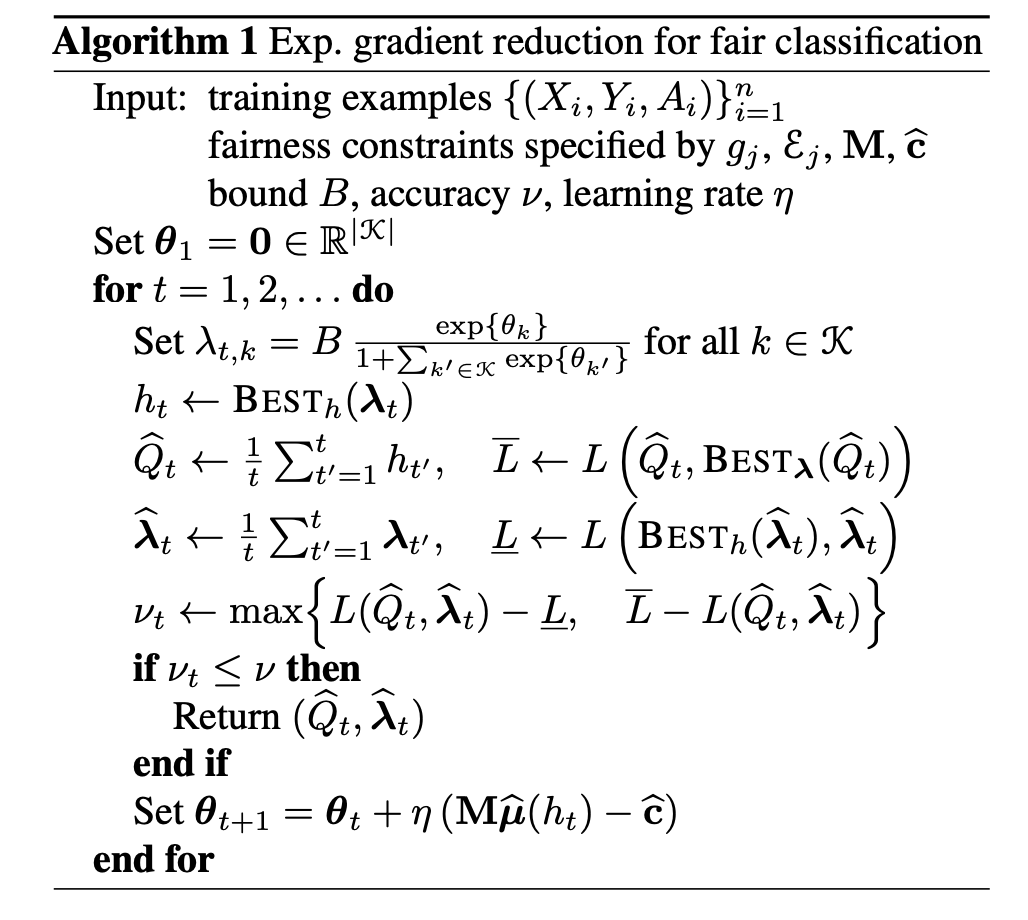

In [ ]:
sens_pred_mitigator, mitigator_case_indices = CSMIA_attack(mitigator, X_train, y_tr, ds.ds.meta)
correct_indices_mitigator = (sens_pred_mitigator == X_train[['MAR_1']].to_numpy().ravel())

subgroup_csmia_case_dict_mitigator = {
    i: X_train.iloc[np.argwhere(mitigator_case_indices[i]).ravel()][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
}
subgroup_csmia_case_correct_dict_mitigator = {
    i: X_train.iloc[np.intersect1d(np.argwhere(mitigator_case_indices[i]).ravel(), np.argwhere(correct_indices_mitigator).ravel())][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
}

temp_dict = {
    f'Case {i}': { j: f'{subgroup_csmia_case_dict_mitigator[i][j]} ({round(100 * subgroup_csmia_case_correct_dict_mitigator[i][j] / subgroup_csmia_case_dict_mitigator[i][j], 2)})' for j in [1, 0] } for i in range(1, 4)
}
temp_dict['All Cases'] = { j: f'{subgroup_csmia_case_dict_mitigator[1][j] + subgroup_csmia_case_dict_mitigator[2][j] + subgroup_csmia_case_dict_mitigator[3][j]} ({round(100 * (subgroup_csmia_case_correct_dict_mitigator[1][j] + subgroup_csmia_case_correct_dict_mitigator[2][j] + subgroup_csmia_case_correct_dict_mitigator[3][j]) / (subgroup_csmia_case_dict_mitigator[1][j] + subgroup_csmia_case_dict_mitigator[2][j] + subgroup_csmia_case_dict_mitigator[3][j]), 2)})' for j in [1, 0] }

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df

In [ ]:
sens_pred_mitigator, mitigator_case_indices = CSMIA_attack(clf, X_train, y_tr, ds.ds.meta)
correct_indices_mitigator = (sens_pred_mitigator == X_train[['MAR_1']].to_numpy().ravel())

subgroup_csmia_case_dict_mitigator = {
    i: X_train.iloc[np.argwhere(mitigator_case_indices[i]).ravel()][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
}
subgroup_csmia_case_correct_dict_mitigator = {
    i: X_train.iloc[np.intersect1d(np.argwhere(mitigator_case_indices[i]).ravel(), np.argwhere(correct_indices_mitigator).ravel())][f'{subgroup_col_name}_1'].value_counts() for i in range(1, 4)
}

temp_dict = {
    f'Case {i}': { j: f'{subgroup_csmia_case_dict_mitigator[i][j]} ({round(100 * subgroup_csmia_case_correct_dict_mitigator[i][j] / subgroup_csmia_case_dict_mitigator[i][j], 2)})' for j in [1, 0] } for i in range(1, 4)
}
temp_dict['All Cases'] = { j: f'{subgroup_csmia_case_dict_mitigator[1][j] + subgroup_csmia_case_dict_mitigator[2][j] + subgroup_csmia_case_dict_mitigator[3][j]} ({round(100 * (subgroup_csmia_case_correct_dict_mitigator[1][j] + subgroup_csmia_case_correct_dict_mitigator[2][j] + subgroup_csmia_case_correct_dict_mitigator[3][j]) / (subgroup_csmia_case_dict_mitigator[1][j] + subgroup_csmia_case_dict_mitigator[2][j] + subgroup_csmia_case_dict_mitigator[3][j]), 2)})' for j in [1, 0] }

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df

In [ ]:
print(round(X_train['SEX_1'].corr(pd.Series(np.argmax(mitigator._pmf_predict(X_train), axis=1))), 6))
print(round(X_train['MAR_1'].corr(pd.Series(np.argmax(mitigator._pmf_predict(X_train), axis=1))), 6))

In [ ]:
dfs = [X_train.copy() for _ in range(len(ds.ds.meta["sensitive_values"]))]
sensitive_columns = [f'{ds.ds.meta["sensitive_column"]}_{i}' for i in range(len(ds.ds.meta["sensitive_values"]))]
for i in range(len(dfs)):
    dfs[i][sensitive_columns] = 0
    dfs[i][f'{ds.ds.meta["sensitive_column"]}_{i}'] = 1

y_preds = [mitigator.predict(df)==y_tr.ravel() for df in dfs]
y_preds = np.array(y_preds).T

case1_indices = (y_preds.sum(axis=1) == 1)

X_train.iloc[case1_indices]['RAC1P_1'].value_counts()

In [ ]:
dfs = [X_train.copy() for _ in range(len(ds.ds.meta["sensitive_values"]))]
sensitive_columns = [f'{ds.ds.meta["sensitive_column"]}_{i}' for i in range(len(ds.ds.meta["sensitive_values"]))]
for i in range(len(dfs)):
    dfs[i][sensitive_columns] = 0
    dfs[i][f'{ds.ds.meta["sensitive_column"]}_{i}'] = 1

y_preds = [np.argmax(clf.predict_proba(df), axis=1)==y_tr.ravel() for df in dfs]
y_preds = np.array(y_preds).T

case1_indices = (y_preds.sum(axis=1) == 1)

X_train.iloc[case1_indices]['RAC1P_1'].value_counts()

In [ ]:
temp_dict = {}
for thr in np.linspace(0.05, 1.0, 20):
    try:
        thr = round(thr, 2)
        target_values = np.max(clf.predict_proba(X_temp_CSMIA), axis=1)
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_csmia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(correct_indices_CSMIA).ravel())
        csmia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_csmia = correct_csmia_indices_shap_cond.shape[0] / csmia_indices_shap_cond.shape[0]
        # print(f"Shap value range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        ratio_correct_csmia_case_dict = {
            i : np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] / np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        total_csmia_case_dict = {
            i : np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        subgroup_csmia_case_dict = {
            i: X_train.iloc[np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel())]['RAC1P_1'].value_counts() for i in range(1, 4)
        }
        subgroup_csmia_case_correct_dict = {
            i: X_train.iloc[np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel())]['RAC1P_1'].value_counts() for i in range(1, 4)
        }
        temp_dict[thr] = {
            'Prediction Confidence': f"[{round(thr-0.05, 2)}, {thr}]",
            'correct ratio': round(ratio_correct_csmia, 4),
            # 'correct': correct_csmia_indices_shap_cond.shape[0],
            'total': csmia_indices_shap_cond.shape[0],
            # 'correct ratio case 1': f"{round(100 * ratio_correct_csmia_case_dict[1], 2)} ({total_csmia_case_dict[1]})",
            # 'correct ratio case 2': f"{round(100 * ratio_correct_csmia_case_dict[2], 2)} ({total_csmia_case_dict[2]})",
            # 'correct ratio case 3': f"{round(100 * ratio_correct_csmia_case_dict[3], 2)} ({total_csmia_case_dict[3]})",
            # 'subgroup case 1 (1 + 0)': f"{subgroup_csmia_case_dict[1][1]} + {subgroup_csmia_case_dict[1][0]}",
            # 'subgroup case 2 (1 + 0)': f"{subgroup_csmia_case_dict[2][1]} + {subgroup_csmia_case_dict[2][0]}",
            # 'subgroup case 3 (1 + 0)': f"{subgroup_csmia_case_dict[3][1]} + {subgroup_csmia_case_dict[3][0]}",
            'subgroup case 1 (1 + 0)': f"{subgroup_csmia_case_dict[1][1]} ({round(100 * subgroup_csmia_case_correct_dict[1][1]/ subgroup_csmia_case_dict[1][1], 2)}) + {subgroup_csmia_case_dict[1][0]} ({round(100 * subgroup_csmia_case_correct_dict[1][0]/ subgroup_csmia_case_dict[1][0], 2)})",
            'subgroup case 2 (1 + 0)': f"{subgroup_csmia_case_dict[2][1]} ({round(100 * subgroup_csmia_case_correct_dict[2][1]/ subgroup_csmia_case_dict[2][1], 2)}) + {subgroup_csmia_case_dict[2][0]} ({round(100 * subgroup_csmia_case_correct_dict[2][0]/ subgroup_csmia_case_dict[2][0], 2)})",
            'subgroup case 3 (1 + 0)': f"{subgroup_csmia_case_dict[3][1]} ({round(100 * subgroup_csmia_case_correct_dict[3][1]/ subgroup_csmia_case_dict[3][1], 2)}) + {subgroup_csmia_case_dict[3][0]} ({round(100 * subgroup_csmia_case_correct_dict[3][0]/ subgroup_csmia_case_dict[3][0], 2)})"
        }
    except:
        # print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Prediction Confidence']
temp_df = temp_df.drop(columns=['Prediction Confidence'])
temp_df

In [ ]:
np.argwhere(((y_tr_onehot[case_indices[3]] * clf.predict_proba(X_temp_CSMIA.iloc[case_indices[3]])).sum(axis=1) - (y_tr_onehot[case_indices[3]] * clf.predict_proba(X_temp_CSMIA_p.iloc[case_indices[3]])).sum(axis=1)) > 0.5)

In [ ]:
((y_tr_onehot[case_indices[3]] * clf.predict_proba(X_temp_CSMIA.iloc[case_indices[3]])).sum(axis=1) - (y_tr_onehot[case_indices[3]] * clf.predict_proba(X_temp_CSMIA_p.iloc[case_indices[3]])).sum(axis=1))[3350]

In [ ]:
X_temp_CSMIA_p = X_temp_CSMIA.copy()
X_temp_CSMIA_p[['MAR_0', 'MAR_1']] = 1 - X_temp_CSMIA_p[['MAR_0', 'MAR_1']]
conf_gaps = (y_tr_onehot * clf.predict_proba(X_temp_CSMIA)).sum(axis=1) - (y_tr_onehot * clf.predict_proba(X_temp_CSMIA_p)).sum(axis=1)

temp_dict = {}
for thr in np.linspace(0.05, 1.0, 20):
    try:
        thr = round(thr, 2)
        target_values = conf_gaps
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_csmia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(correct_indices_CSMIA).ravel())
        csmia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_csmia = correct_csmia_indices_shap_cond.shape[0] / csmia_indices_shap_cond.shape[0]
        # ratio_correct_csmia_case_1 = np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[1]).ravel()).shape[0] / np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[1]).ravel()).shape[0]
        # ratio_correct_csmia_case_2 = np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[2]).ravel()).shape[0] / np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[2]).ravel()).shape[0]
        ratio_correct_csmia_case_dict = {
            i : np.intersect1d(correct_csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] / np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        total_csmia_case_dict = {
            i : np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel()).shape[0] for i in range(1, 4)
        }
        subgroup_csmia_case_dict = {
            i: X_train.iloc[np.intersect1d(csmia_indices_shap_cond, np.argwhere(case_indices[i]).ravel())]['RAC1P_1'].value_counts() for i in range(1, 4)
        }
        # print(f"Shap value range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        temp_dict[thr] = {
            'Confidence Gap': f"[{round(thr-0.05, 2)}, {thr}]",
            'correct ratio': round(ratio_correct_csmia, 4),
            'correct': correct_csmia_indices_shap_cond.shape[0],
            'total': csmia_indices_shap_cond.shape[0],
            'correct ratio case 1': f"{round(ratio_correct_csmia_case_dict[1], 4)} ({total_csmia_case_dict[1]})",
            'correct ratio case 2': f"{round(ratio_correct_csmia_case_dict[2], 4)} ({total_csmia_case_dict[2]})",
            'correct ratio case 3': f"{round(ratio_correct_csmia_case_dict[3], 4)} ({total_csmia_case_dict[3]})",
            'subgroup case 1 (1 + 0)': f"{subgroup_csmia_case_dict[1][1]} + {subgroup_csmia_case_dict[1][0]}",
            'subgroup case 2 (1 + 0)': f"{subgroup_csmia_case_dict[2][1]} + {subgroup_csmia_case_dict[2][0]}",
            'subgroup case 3 (1 + 0)': f"{subgroup_csmia_case_dict[3][1]} + {subgroup_csmia_case_dict[3][0]}",
            # 'correct ratio case 2': round(ratio_correct_csmia_case_dict[2], 4),
            # 'correct ratio case 3': round(ratio_correct_csmia_case_dict[3], 4),
        }
    except:
        # print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Confidence Gap']
temp_df = temp_df.drop(columns=['Confidence Gap'])
temp_df

In [ ]:
import shap
target_model = model_utils.port_mlp_to_ch(clf)

def f(X):
    # X_tensor = torch.from_numpy(X.to_numpy()).float().to(model_utils.device)
    X_tensor = torch.from_numpy(X).float().to(model_utils.device)
    predictions = target_model(X_tensor)
    # predictions is of shape (batch_size, 2) and contains the logits
    # for each data point in the batch, we need to return the class with the highest probability
    # we can do this by taking the argmax of the logits
    return predictions.argmax(dim=1).detach().cpu().numpy()

X_temp = attack_df.copy().drop(columns=[ds.ds.meta['y_column']])
y_temp = attack_df[ds.ds.meta['y_column']]

background = shap.kmeans(X_temp, 10)
explainer = shap.KernelExplainer(f, background)
shap_values = explainer.shap_values(X_temp, nsamples=100)

save_shap_values = False
if save_shap_values:
    np.save(f'<PATH_TO_SHAP_VALUES>/{ds.ds.filenameroot}_{ds.ds.meta["sensitive_column"]}_shap_values.npy', shap_values)

In [ ]:
subgroup_lomia_correct_indices = {
    val: np.intersect1d(subgroup_indices_dict[val], lomia_correct_indices) for val in subgroup_col_values
}
subgroup_lomia_indices = {
    val: np.intersect1d(subgroup_indices_dict[val], lomia_indices) for val in subgroup_col_values
}
subgroup_correct_lomia_case1_ratio = {
    val: subgroup_lomia_correct_indices[val].shape[0] / subgroup_lomia_indices[val].shape[0] for val in subgroup_col_values
}

In [ ]:
subgroup_correct_lomia_case1_ratio

In [ ]:
shap_values.shape

In [ ]:
# shap_values = np.load(f'<PATH_TO_SHAP_VALUES>/{ds.ds.filenameroot}_{ds.ds.meta["sensitive_column"]}_shap_values.npy')

sens_indices = [cols.get_loc(f'{ds.ds.meta["sensitive_column"]}_{val}') for val in ds.ds.meta["sensitive_values"]]
sensitive_col_shap_values = shap_values[:, sens_indices]

+ ~65% of the LOMIA case 1 samples have the correct sensitive attribute value
+ If we can find a way to separate the correct case 1 samples, the attack model trained on the filtered data will be more effective
+ Below we try to see if the correct and incorrect case 1 samples have different shap values

In [ ]:
temp_dict = {}
for thr in np.linspace(-0.6, 0.6, 25):
    try:
        thr = round(thr, 2)
        target_values = sensitive_col_shap_values[:, 0]
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_lomia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(np.isin(lomia_indices, lomia_correct_indices)))
        lomia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_lomia_case1 = correct_lomia_indices_shap_cond.shape[0] / lomia_indices_shap_cond.shape[0]
        # print(f"Shap value range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        temp_dict[thr] = {
            'Shap Value': f"[{round(thr-0.05, 2)}, {thr}]",
            'correct case 1 ratio': round(ratio_correct_lomia_case1, 4),
            'correct': correct_lomia_indices_shap_cond.shape[0],
            'total': lomia_indices_shap_cond.shape[0]
        }
    except:
        # print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Shap Value']
temp_df = temp_df.drop(columns=['Shap Value'])
temp_df

Now we try to see if the correct and incorrect case 1 samples have different prediction confidence

In [ ]:
temp_dict = {}
for thr in np.linspace(0.55, 1.0, 10):
    try:
        thr = round(thr, 2)
        target_values = np.max(clf.predict_proba(X_temp), axis=1)
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_lomia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(np.isin(lomia_indices, lomia_correct_indices)))
        lomia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_lomia_case1 = correct_lomia_indices_shap_cond.shape[0] / lomia_indices_shap_cond.shape[0]
        # print(f"Prediction Confidence Range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        temp_dict[thr] = {
            'Prediction Confidence': f"[{round(thr-0.05, 2)}, {thr}]",
            'correct case 1 ratio': round(ratio_correct_lomia_case1, 4),
            'correct': correct_lomia_indices_shap_cond.shape[0],
            'total': lomia_indices_shap_cond.shape[0]
        }
    except:
        print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Prediction Confidence']
temp_df = temp_df.drop(columns=['Prediction Confidence'])
temp_df

In [ ]:
X_temp_p = X_temp.copy()
X_temp_p[['MAR_0', 'MAR_1']] = 1 - X_temp_p[['MAR_0', 'MAR_1']]
conf_gaps = np.max(clf.predict_proba(X_temp), axis=1) - (y_tr_onehot[lomia_indices] * clf.predict_proba(X_temp_p)).sum(axis=1)

temp_dict = {}
for thr in np.linspace(0.05, 1, 20):
    try:
        thr = round(thr, 2)
        target_values = conf_gaps
        shap_value_cond_filter = np.intersect1d(np.argwhere(target_values < thr).ravel(), np.argwhere(target_values > thr - 0.05).ravel())
        correct_lomia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), np.argwhere(np.isin(lomia_indices, lomia_correct_indices)))
        lomia_indices_shap_cond = np.argwhere(shap_value_cond_filter).ravel()
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_lomia_case1 = correct_lomia_indices_shap_cond.shape[0] / lomia_indices_shap_cond.shape[0]
        # print(f"Prediction Confidence Gap: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
        temp_dict[thr] = {
            'Prediction Confidence Gap': f"[{round(thr-0.05, 2)}, {thr}]",
            'correct case 1 ratio': round(ratio_correct_lomia_case1, 4),
            'correct': correct_lomia_indices_shap_cond.shape[0],
            'total': lomia_indices_shap_cond.shape[0]
        }
    except:
        print(shap_value_cond_filter)
        pass

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
temp_df.index = temp_df['Prediction Confidence Gap']
temp_df = temp_df.drop(columns=['Prediction Confidence Gap'])
temp_df

In [ ]:
y_tr[lomia_indices].ravel() == np.argmax(clf.predict_proba(X_temp), axis=1)

In [ ]:
for thr in np.linspace(-0.6, 0.6, 25):
    try:
        thr = round(thr, 2)
        shap_value_cond_filter = np.intersect1d(np.argwhere(sensitive_col_shap_values[:, 0] < thr).ravel(), np.argwhere(sensitive_col_shap_values[:, 0] > thr - 0.05).ravel())
        correct_lomia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices)
        lomia_indices_shap_cond = np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices)
        # np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(shap_value_cond_filter).ravel(), lomia_indices).shape[0]
        ratio_correct_lomia_case1 = correct_lomia_indices_shap_cond.shape[0] / lomia_indices_shap_cond.shape[0]
        print(f"Shap value range: [{round(thr-0.05, 2)}, {thr}], correct case 1 ratio: {ratio_correct_lomia_case1}, correct: {correct_lomia_indices_shap_cond.shape[0]}, total: {lomia_indices_shap_cond.shape[0]}")
    except:
        pass

In [ ]:
# calculate correlation between each column of shap_values and the correctness of the lomia indices samples
lomia_correct = np.zeros(shap_values.shape[0])
lomia_correct[lomia_correct_indices] = 1
lomia_correct = lomia_correct.astype(bool)
lomia_correct = lomia_correct[lomia_indices]
lomia_correct = lomia_correct.astype(int)
lomia_shap_values = shap_values[lomia_indices, :]
for i in range(lomia_shap_values.shape[1]):
    print(f"Correlation between shap value of column {i} and lomia correctness: {np.corrcoef(lomia_shap_values[:, i], lomia_correct)[0, 1]}")

In [ ]:
np.intersect1d(np.argwhere(y_pred_conf > 0.5).ravel(), lomia_correct_indices).shape[0] / np.intersect1d(np.argwhere(y_pred_conf > 0.5).ravel(), lomia_indices).shape[0]

In [ ]:
np.intersect1d(np.argwhere(y_pred_conf > 0.5).ravel(), lomia_indices).shape[0]

In [ ]:
clf.predict_proba(X_train)[lomia_indices]

In [ ]:
(np.argmax(clf.predict_proba(X_train), axis=1) == y_tr.ravel()).sum()

In [ ]:
y_pred[lomia_indices]

In [ ]:
sns.displot(y_pred_conf[lomia_correct_indices], label='correct')

In [ ]:
sns.displot(y_pred_conf[lomia_indices], label='correct')

In [ ]:
sens_indices = [cols.get_loc(f'{ds.ds.meta["sensitive_column"]}_{val}') for val in ds.ds.meta["sensitive_values"]]
sensitive_col_shap_values = shap_values[:, sens_indices]

In [ ]:
sns.scatterplot(x=sensitive_col_shap_values[correct_indices.to_numpy(), 1], y=y_pred_conf[correct_indices.to_numpy()], alpha=0.1)

In [ ]:
sns.scatterplot(x=sensitive_col_shap_values[incorrect_indices.to_numpy(), 1], y=y_pred_conf[incorrect_indices.to_numpy()], alpha=0.1)

# Permutation Importance vs LOMIA Attack Performance on Different Subgroups

In [ ]:
def get_perm_imp(r):
    result_mean, result_std = {}, {}
    # for i in r.importances_mean.argsort()[::-1]:
    for i in range(len(r.importances_mean)):
        # if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        # print(i)
        if cols[i] in all_sensitive_col_full_names:
            # print(f"{cols[i]} "
            #     f"{r.importances_mean[i]:.8f}"
            #     f" +/- {r.importances_std[i]:.8f}")
            result_mean[cols[i]] = r.importances_mean[i]
            result_std[cols[i]] = r.importances_std[i]

    return result_mean, result_std

all_sensitive_col_full_names = [f'{col}' for col in cols.to_numpy() if col.split('_')[0] in all_sensitive_columns + ['MAR']]

r_rac1ps = []

for i in range(2):
    rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': i})
    r_rac1ps.append(permutation_importance(clf, X_train.loc[rac1p_indices,:] , ds.ds.y_enc.transform(y_tr[rac1p_indices.to_numpy()]).toarray(),
                            n_repeats=30,
                            random_state=0))
    
perm_imps_race = {
    i: get_perm_imp(r_rac1ps[i])[0] for i in range(2)
}
# perm_imps_race['all'] = get_perm_imp(r_train)[0]

In [ ]:
perm_imps_race_df = pd.DataFrame(perm_imps_race)

# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_race_df.loc[col] = results_race_df.loc[f'{col}_1'] / results_race_df.loc[f'{col}_0']

    # results_race_df.loc[col] = results_race_df.loc[col] / results_race_df.loc[col]['all']

perm_imps_race_df

In [ ]:
aucs_df = pd.DataFrame(aucs, columns=['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']).T

aucs_df

In [ ]:
recalls_df = pd.DataFrame(recalls, columns=['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']).T
recalls_df

# Model Inversion with Full Records

In [ ]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)
y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

In [ ]:
save_model = True

try:
    inv_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_inverse_model.pkl')
except:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=0.9, random_state=42)

    inv_clf = model_utils.get_model(max_iter=500)
    inv_clf.fit(x_tr, y_tr)
    # inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
    # inv_clfs[test_size] = inv_clf

    acc = 100 * inv_clf.score(x_te, y_te)
    print(f'Inverse accuracy with test size : {acc}')

    if save_model:
        model_utils.save_model(inv_clf, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_inverse_model.pkl')

In [ ]:
save_model = True
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

subgroup_disparity_dicts = {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    y_onehot = temp_ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

    subgroup_columns = ['RAC1P']

    try:
        inv_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_inverse_model_{sensitive_column}.pkl')

    except:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=0.9, random_state=42)

        inv_clf = model_utils.get_model(max_iter=500)
        inv_clf.fit(x_tr, y_tr)
        # inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        # inv_clfs[test_size] = inv_clf

        acc = 100 * inv_clf.score(x_te, y_te)
        print(f'Inverse accuracy with test size : {acc}')

        if save_model:
            model_utils.save_model(inv_clf, f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_inverse_model_{sensitive_column}.pkl')
    
    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='INV', ds=ds, subgroup_columns=['RAC1P'], X_att_query=X, y_att_query=y, metric='auc', clf=inv_clf)
    subgroup_disparity_dicts[sensitive_column] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
load_model = False
save_model = False

if load_model:
    inv_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')
else:

    inv_clfs = {}

    for test_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

        # inv_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(60, 50, 40, 30, 20, 10))
        # pca_clf.fit(x_tr, y_tr)
        inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        inv_clfs[test_size] = inv_clf

        acc = 100 * inv_clf.score(x_te, y_te)
        print(f'Inverse accuracy with test size {test_size}: {acc}')

    if save_model:
        model_utils.save_model(inv_clfs, f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')

In [ ]:
inv_names = []
inv_aucs = []

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

    inv_clf = inv_clfs[test_size]
    
    # calculate auc
    y_pred = inv_clf.predict_proba(x_te)
    auc = roc_auc_score(y_te, y_pred)
    inv_names.append(f'Inverse-{round((1-test_size)*100)}%')
    inv_aucs.append(auc*100)
    print(f'AUC with test size {test_size}: {auc}')

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

inv_clf = inv_clfs[test_size]
subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, inv_clf, x_te, y_te, metric='auc')

In [ ]:
subgroup_disparity_dict

# Grad Approach

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Step 1: Prepare the dataset
# Assuming you have already loaded and preprocessed the GSS dataset
X_train_for_grad, X_test_for_grad, y_train_for_grad, y_test_for_grad = torch.tensor(x_tr, dtype=torch.float32, requires_grad=True), torch.tensor(x_te, dtype=torch.float32, requires_grad=True), torch.tensor(y_tr, dtype=torch.float32, requires_grad=True), torch.tensor(y_te, dtype=torch.float32, requires_grad=True)

# Step 2: Create a custom dataset
class GradAttDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = torch.Tensor(self.features[index])
        y = torch.Tensor([self.labels[index]])
        return x, y

train_dataset = GradAttDataset(X_train_for_grad, y_train_for_grad)
test_dataset = GradAttDataset(X_test_for_grad, y_test_for_grad)

# Step 8: Train the model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
all_sensitive_columns = ['default', 'DEAR', 'DEYE', 'DREM', 'DPHY']

In [ ]:
def check_if_grad_stored():
    # check if the following list of files exist
    # if they do, then we have already stored the gradients
    # if not, then we need to store the gradients
    filenames = [f'grads/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy' for sens_col in all_sensitive_columns]
    return all([os.path.exists(filename) for filename in filenames])

if not check_if_grad_stored():
    for i, sens_col in enumerate(all_sensitive_columns):
        meta = data_utils.CensusWrapper(name='Census19', sensitive_column=sens_col, preload=False).ds.meta
        sens_indices = [cols.get_loc(f'{meta["sensitive_column"]}_{val}') for val in meta["sensitive_values"]]
        sens_attrs = []
        scores = []
        orig_grads = []
        grads_after_flip = []
        y_trues = []
        
        target_model = port_mlp_to_ch(clf)
        optim = torch.optim.Adam(target_model.parameters(), lr=0.001)
        # for batch in tqdm(train_loader):
        for idx, batch in enumerate(train_loader):
            # if idx > 100:
            #     break
            optim.zero_grad()
            # batch = next(iter(train_loader))
            x, y = batch
            x, y = x.to('mps'), y.to('mps')
            y_pred = target_model(x)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(y_pred, y.long().reshape(-1))
            # loss = nn.CrossEntropyLoss()(y_pred, y.long())
            loss.backward()
            grad = [p.grad.clone().detach().cpu().numpy().reshape(-1) for p in target_model.parameters()]
            grad = np.concatenate(grad)
            orig_grads.append(grad)

            optim.zero_grad()
            x_np = x.clone().detach().cpu().numpy()
            # x_np[0,55:57] = 1 - x_np[0,55:57]
            x_np[0, sens_indices] = 1 - x_np[0, sens_indices]
            x_clone = torch.tensor(x_np, requires_grad=True).to('mps')
            y_pred2 = target_model(x_clone)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(y_pred2, y.long().reshape(-1))
            loss.backward()
            grad2 = [p.grad.clone().detach().cpu().numpy().reshape(-1) for p in target_model.parameters()]
            grad2 = np.concatenate(grad2)
            grads_after_flip.append(grad2)

            # if x_np[0,55] == 1:
            if x_np[0, sens_indices[0]] == 1:
                sens_attr = 0
                # score = np.linalg.norm(grad) - np.linalg.norm(grad2)
                score = np.linalg.norm(grad - grad2)
            else:
                sens_attr = 1
                # score = np.linalg.norm(grad2) - np.linalg.norm(grad)
                score = np.linalg.norm(grad2 - grad)

            sens_attrs.append(sens_attr)
            scores.append(score)

        orig_grads = np.array(orig_grads)
        grads_after_flip = np.array(grads_after_flip)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy', orig_grads)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy', grads_after_flip)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy', sens_attrs)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy', scores)

In [ ]:
all_sensitive_columns = ['default', 'DEAR', 'DEYE', 'DREM', 'DPHY']

aucs, recalls = {}, {}

subgroup_disparity_dicts = {}

for sens_col in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sens_col)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')

    tpr, fpr, thresholds = roc_curve(sens_attrs, scores)
    # get the threshold with tpr = 0.5
    best_threshold = thresholds[np.argmin(np.abs(tpr - 0.5))]
    # best_threshold = thresholds[np.argmax(tpr - fpr)]


    subgroup_columns = ['RAC1P', 'SEX']

    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='GRAD', ds=ds, X_att_query=X, y_att_query=y, y_pred=scores, threshold=best_threshold, subgroup_columns=subgroup_columns, metric='recall')

    subgroup_disparity_dicts[sens_col] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
original_aucs = {}

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')

    print(f'For {sens_col}')
    auc = roc_auc_score(sens_attrs, scores)
    original_aucs[sens_col] = auc
    print(f'AUC: {auc}')

In [ ]:
auc_dict_sex = {
    'male': {},
    'female': {},
    'all': {},
}

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')

    # print(f'For {sens_col}')
    # auc = roc_auc_score(sens_attrs, scores)
    auc_dict_sex['male'][sens_col] = roc_auc_score(sens_attrs[male_indices.to_numpy()], scores[male_indices.to_numpy()])
    auc_dict_sex['female'][sens_col] = roc_auc_score(sens_attrs[female_indices.to_numpy()], scores[female_indices.to_numpy()])

    # print(f'AUC: {auc}')
    auc_dict_sex['all'][sens_col] = original_aucs[sens_col]

In [ ]:
auc_dict_race = { i: {} for i in range(2) }
auc_dict_race['all'] = {}

race_marginal_prior_dict = (100 * ds.ds.original_df['RAC1P'].value_counts() / len(ds.ds.original_df)).to_dict()

for i in range(2):
    auc_dict_race[i]['marginal prior'] = race_marginal_prior_dict[i]
auc_dict_race['all']['marginal prior'] = 100

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')
    

    for idx in range(2):
        rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': idx})
        try:
            auc_dict_race[idx][sens_col] = roc_auc_score(sens_attrs[rac1p_indices.to_numpy()], scores[rac1p_indices.to_numpy()])
        except:
            auc_dict_race[idx][sens_col] = np.nan

    auc_dict_race['all'][sens_col] = original_aucs[sens_col]

In [ ]:
auc_dict_race

In [ ]:
all_sensitive_col_full_names = [f'{col}' for col in cols.to_numpy() if col.split('_')[0] in all_sensitive_columns + ['MAR']]

In [ ]:
male_indices = get_indices_by_conditions(ds, X_train, {'SEX': 0})
female_indices = get_indices_by_conditions(ds, X_train, {'SEX': 1})

In [ ]:
r_male = permutation_importance(clf, X_train.loc[male_indices,:] , ds.ds.y_enc.transform(y_tr[male_indices.to_numpy()]).toarray(),
                           n_repeats=30,
                           random_state=0)

In [ ]:
r_female = permutation_importance(clf, X_train.loc[female_indices,:] , ds.ds.y_enc.transform(y_tr[female_indices.to_numpy()]).toarray(),
                           n_repeats=30,
                           random_state=0)

In [ ]:
r_rac1ps = []

for i in range(2):
    rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': str(i)})
    r_rac1ps.append(permutation_importance(clf, X_train.loc[rac1p_indices,:] , ds.ds.y_enc.transform(y_tr[rac1p_indices.to_numpy()]).toarray(),
                            n_repeats=30,
                            random_state=0))

In [ ]:
def get_perm_imp(r):
    result_mean, result_std = {}, {}
    # for i in r.importances_mean.argsort()[::-1]:
    for i in range(len(r.importances_mean)):
        # if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        # print(i)
        if cols[i] in all_sensitive_col_full_names:
            # print(f"{cols[i]} "
            #     f"{r.importances_mean[i]:.8f}"
            #     f" +/- {r.importances_std[i]:.8f}")
            result_mean[cols[i]] = r.importances_mean[i]
            result_std[cols[i]] = r.importances_std[i]

    return result_mean, result_std


In [ ]:
results = {
    'male': get_perm_imp(r_male)[0],
    'female': get_perm_imp(r_female)[0],
    'all': get_perm_imp(r_train)[0],
}

In [ ]:
results_race = {
    i: get_perm_imp(r_rac1ps[i])[0] for i in range(2)
}
results_race['all'] = get_perm_imp(r_train)[0]

In [ ]:
results_sex_df = pd.DataFrame(results)
# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_sex_df.loc[col] = results_sex_df.loc[f'{col}_1'] / results_sex_df.loc[f'{col}_0']

    # results_sex_df.loc[col] = results_sex_df.loc[col] / results_sex_df.loc[col]['all']

results_sex_df

In [ ]:
pd.DataFrame(auc_dict_sex, index=['default', 'DREM', 'DPHY', 'DEAR', 'DEYE'])

In [ ]:
results_race_df = pd.DataFrame(results_race)

# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_race_df.loc[col] = results_race_df.loc[f'{col}_1'] / results_race_df.loc[f'{col}_0']

    # results_race_df.loc[col] = results_race_df.loc[col] / results_race_df.loc[col]['all']

results_race_df

In [ ]:
auc_race_df = pd.DataFrame(auc_dict_race, index=['marginal prior', 'default', 'DREM', 'DPHY', 'DEAR', 'DEYE'])
auc_race_df = auc_race_df.rename(index={'default': 'MAR'})
auc_race_df

# PCA Approach

In [ ]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)
y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

In [ ]:
save_model = True
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

subgroup_disparity_dicts = {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)
    y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

    subgroup_columns = ['RAC1P']

    try:
        pca_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_pca_model_{sensitive_column}.pkl')
        with open(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_pca_model_pca_{sensitive_column}.pkl', 'rb') as f:
            pca = pickle.load(f)
    except:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=0.9, random_state=42)

        pca = PCA(n_components=2)
        pca.fit(x_tr)
            
        x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

        pca_clf = model_utils.get_model(max_iter=500)
        pca_clf.fit(x_tr, y_tr)

        if save_model:
            model_utils.save_model(pca_clf, f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_pca_model_{sensitive_column}.pkl')
            with open(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_pca_model_pca_{sensitive_column}.pkl', 'wb') as f:
                pickle.dump(pca, f)

    X = pd.DataFrame(pca.transform(X), index=X.index)
    
    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='PCA', ds=ds, subgroup_columns=['RAC1P'], X_att_query=X, y_att_query=y, metric='auc', clf=pca_clf)
    subgroup_disparity_dicts[sensitive_column] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
load_model = True
save_model = False

if load_model:
    pca_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_pca_model.pkl')
else:

    pca_clfs = {}

    pca_clfs['pca'] = {}

    for test_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

        pca = PCA(n_components=2)
        pca.fit(x_tr)
        pca_clfs['pca'][test_size] = pca
        x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

        # inv_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(60, 50, 40, 30, 20, 10))
        # inv_clf.fit(x_tr, y_tr)
        pca_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        pca_clfs[test_size] = pca_clf

        acc = 100 * pca_clf.score(x_te, y_te)
        print(f'PCA accuracy with test size {test_size}: {acc}')

    if save_model:
        model_utils.save_model(pca_clfs, f'<PATH_TO_MODEL>/{ds.ds.name}_pca_model.pkl')

In [ ]:
# plot the data in 2D
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]
x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

x_te = x_te.to_numpy()

# sample only 100 points from x_te and y_te to plot
x_te, y_te = map(lambda x: x[:1000], [x_te, y_te])

# y_te has values 0 or 1
# use y_te to get the color
colors = ['red', 'blue']
for i in range(len(x_te)):
    ax.scatter(x_te[i, 0], x_te[i, 1], color=colors[y_te[i].argmax()])
plt.show()


In [ ]:
pca_names = []
pca_aucs = []

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

    pca_clf = pca_clfs[test_size]
    pca = pca_clfs['pca'][test_size]

    x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])
    
    # calculate auc
    y_pred = pca_clf.predict_proba(x_te)
    auc = roc_auc_score(y_te, y_pred)
    pca_names.append(f'Inverse-{round((1-test_size)*100)}%')
    pca_aucs.append(auc*100)
    print(f'AUC with test size {test_size}: {auc}')

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]

x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

for col in subgroup_columns:
    values = ds.ds.unique_values_dict[col]
    subgroup_asrs = {}
    subgroup_dists = {}

    for val in values:
        if len(get_indices_by_conditions(ds, X, {col:val})) > 500:
            indices = get_indices_by_conditions(ds, x_te, {col:val})
            x_te_subgroup = x_te.loc[indices]
            y_te_subgroup = y_te.loc[indices]

            # calculate the correlation between x_te_subgroup features and the sensitive attribute y_te_subgroup
            corr = x_te_subgroup.corrwith(y_te_subgroup)

            print(f'Correlation between {col}={val} and y: \n {corr}')

            # subgroup_asrs[val] = get_accuracy(ds, {col:val}, neuron_clf, X_neuron, y, metric=metric)
            # subgroup_dists[val] = subgroup_vulnerability_distance(ds, {col:val}, X_neuron)

    # subgroup_disparity_dict[col] = {'asrs':subgroup_asrs, 'dists':subgroup_dists}



In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]

x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, pca_clf, x_te, y_te, metric='auc')
# plot_subgroup_disparity(subgroup_disparity_dict, req_metrics=['asrs'])

In [ ]:
subgroup_disparity_dict

# Investigate Neuron Output

## From LOMIA Case 1

In [ ]:
X_attack_neuron = make_neuron_output_data(ds, X_attack, clf, y_columns)

In [ ]:
neuron_clf = model_utils.get_model(max_iter=500)

In [ ]:
neuron_clf.fit(X_attack_neuron, y_attack_onehot)

## From Original Data

In [ ]:
X, y = ds.ds.get_attack_df()
X = X.astype(np.float32)
X_neuron = make_neuron_output_data(ds, X, clf, ds.ds.y_columns)

In [ ]:
save_model = True
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

subgroup_disparity_dicts = {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    y_onehot = temp_ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

    subgroup_columns = ['RAC1P']

    try:
        neur_ours_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_neurours_model_{sensitive_column}.pkl')

    except:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=0.9, random_state=42)

        x_n_tr = make_neuron_output_data(temp_ds, x_tr, clf, temp_ds.ds.y_columns)
        x_n_te = make_neuron_output_data(temp_ds, x_te, clf, temp_ds.ds.y_columns)

        neur_ours_clf = model_utils.get_model(max_iter=500)
        neur_ours_clf.fit(x_n_tr, y_tr)
        # inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        # inv_clfs[test_size] = inv_clf

        acc = 100 * neur_ours_clf.score(x_n_te, y_te)
        print(f'NeurOurs accuracy with test size : {acc}')

        if save_model:
            model_utils.save_model(neur_ours_clf, f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_neurours_model_{sensitive_column}.pkl')
    
    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='NEUR_OURS', ds=temp_ds, subgroup_columns=['RAC1P'], X_att_query=X, y_att_query=y, metric='recall', clf=neur_ours_clf, df=X, MLP=clf)
    subgroup_disparity_dicts[sensitive_column] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
# subset features of X_neuron: 0:32 and 59:91
X_neuron = X_neuron.iloc[:,np.concatenate((np.arange(0,32), np.arange(59,91)))]

In [ ]:
# find the indices of the data points that are correctly classified by the target model
# the prediction is a one-hot encoded vector, so we need to take the argmax to get the class label
df_x, df_y = ds.ds.df.drop([ds.ds.meta["y_column"], 'is_train'], axis=1), ds.ds.df[[ds.ds.meta["y_column"]]]
correct_indices = np.where(df_y.to_numpy().squeeze() != clf.predict(df_x).argmax(axis=1))[0]

In [ ]:
# get the data points that are correctly classified by the target model
# X, y, X_neuron = X.iloc[correct_indices, :], y.iloc[correct_indices], X_neuron.iloc[correct_indices, :]

In [ ]:
# Split x and y into train and test
load_model = False
save_model = False

test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
# test_sizes = [0.5]

if load_model:
    neuron_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_sizes[0], random_state=42)
    y_n_tr_onehot = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
else:
    neuron_clfs={}

    hidden_layers = [64, 32, 16, 8, 4]

    lomia_case_1_indices = get_LOMIA_case_1_correct_examples(ds, X_train)
    # subset lomia_case_1_indices with the correct indices
    # lomia_case_1_indices = np.intersect1d(lomia_case_1_indices, correct_indices)
    if 'lomia_case_1_indices' in globals():
        x_n_tr, x_n_te, y_n_tr, y_n_te = X_neuron.iloc[lomia_case_1_indices], X_neuron.iloc[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)], y[lomia_case_1_indices], y[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)]

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
        # new_clf = model_utils.get_model(max_iter=2000)
        # # new_clf.set_params(hidden_layer_sizes=hidden_layers)
        # new_clf.set_params(alpha=0.1, solver='adam', activation='relu')
        # neuron_clfs['lomia_case_1'] = new_clf
        # neuron_clfs['lomia_case_1'].fit(x_n_tr, y_n_tr)
        neuron_clfs['lomia_case_1'] = proxy_train_mlp(x_n_tr.to_numpy(), y_n_tr, epochs=100)

    for test_size in test_sizes:
        x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
        
        # new_clf = model_utils.get_model(max_iter=2000)
        # # new_clf.set_params(hidden_layer_sizes=hidden_layers)
        # new_clf.set_params(alpha=0.1, solver='adam', activation='relu')
        # neuron_clfs[test_size] = new_clf
        # neuron_clfs[test_size].fit(x_n_tr, y_n_tr)
        neuron_clfs[test_size] = proxy_train_mlp(x_n_tr.to_numpy(), y_n_tr, epochs=100)

    if save_model:
        model_utils.save_model(neuron_clfs, f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')

## Compare whitebox correlation attack and our attack

In [ ]:
save_model = True
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

subgroup_disparity_dicts = {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict=sampling_condition_dict, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    y_onehot = temp_ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

    subgroup_columns = ['RAC1P']

    x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.9, random_state=42)
    x_n_tr = make_neuron_output_data(temp_ds, x_tr, clf, temp_ds.ds.y_columns)
    x_n_te = make_neuron_output_data(temp_ds, x_te, clf, temp_ds.ds.y_columns)

    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_tr)

    subgroup_disparity_dict = get_disparity_by_subgroup(attack_type='NEUR_IMP', ds=temp_ds, subgroup_columns=['RAC1P'], X_att_query=X, y_att_query=y, metric='auc', clf=top_10_corr_neurons_model, df=X, MLP=clf)
    subgroup_disparity_dicts[sensitive_column] = subgroup_disparity_dict

In [ ]:
subgroup_disparity_dicts

In [ ]:
x_n_tr.to_numpy().shape

In [ ]:
subgroup_disparity_dicts

In [ ]:
top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)
wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
# draw the ROC curve
y_wb_att = y.ravel().astype(np.float32)
fpr, tpr, thresholds = roc_curve(y_wb_att, wb_preds)

roc_curve_plot(fpr, tpr)

In [ ]:
our_preds = neuron_clfs[0.9].predict_proba(X_neuron)[:,1]

fpr, tpr, thresholds = roc_curve(y_wb_att, our_preds)

roc_curve_plot(fpr, tpr)

In [ ]:
names = []
aucs = []
for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)

    # wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
    wb_preds = top_10_corr_neurons_model(torch.from_numpy(x_n_te.to_numpy()).float()).detach().numpy()
    # draw the ROC curve
    y_wb_att = y_n_te.ravel().astype(np.float32)
    names.append(f'wb-corr-{round((1-test_size)*100)}%')
    aucs.append(roc_auc_score(y_wb_att, wb_preds))

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    names.append(f'Ours-{round((1-test_size)*100)}%')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)

    x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

    preds = neuron_clfs[test_size].predict_proba(x_n_te)[:,1]
    y_wb_att = y_n_te.ravel().astype(np.float32)
    aucs.append(roc_auc_score(y_wb_att, preds))

names.append('LOMIA')
lomia_preds = neuron_clfs['lomia_case_1'].predict_proba(x_n_te)[:,1]
aucs.append(roc_auc_score(y_wb_att, lomia_preds))

In [ ]:
aucs

In [ ]:
# plot bars with x ticks as names and y as aucs
# make the yticks vertical
plt.figure(figsize=(18,5))
plt.bar(names + inv_names, (np.array(aucs)*100).tolist() + inv_aucs)
plt.hlines(aucs[4]*100, -1, len(names + inv_names), linestyles='dashed')
# plt.ylim(60, 75)
plt.title('AUCs of different attacks')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_aucs = (np.array(aucs[:-1])*100).tolist() + inv_aucs

# make a 2d numpy array of the aucs with shape (3, -1)
aucs_2d = np.array(all_aucs).reshape(3, -1)

In [ ]:
aucs_2d = pd.DataFrame(aucs_2d, columns=[f'{(i+1)*10}%' for i in range(5)], index=['WB-Corr', 'Ours', 'Inverse'])

In [ ]:
print(aucs_2d.round(2).to_latex(float_format="%.2f"))

In [ ]:
names + inv_names

## Subgroup Biased Neuron

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='accuracy')

print(subgroup_disparity_dict)

# plot_subgroup_disparity(subgroup_disparity_dict, subgroup_columns)

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='auc', dist_percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], epochs=100)

print(subgroup_disparity_dict)

In [ ]:
def highlight_max(row):
    # str_values = row[:2]
    # row = row[2:]
    max_val = row[2:-1].max()
    return ([r'\textbf{{{}}}'.format(val) if type(val) == float and val == max_val else val for val in row])

# round up float values to 2 decimal places
result = subgroup_disparity_dict.round(2)

# sort by 'Subgroup Name' column first and then by 'Marginal Prior' column
result = result.sort_values(by=['Subgroup Name', 'Marginal Prior'], ascending=[False, False])

# convert 'Margin Prior' column to string
result['Marginal Prior'] = result['Marginal Prior'].apply(lambda x: str(x))

result = result.apply(highlight_max, axis=1)

result = pd.DataFrame(result.to_list(), columns=subgroup_disparity_dict.columns)

# sort by 'Subgroup Name' column first and then by 'Marginal Prior' column
# result = result.sort_values(by=['Subgroup Name', 'Marginal Prior'], ascending=[False, False])

# put 'Marginal Prior' column as the 3rd column
cols = result.columns.tolist()
cols = cols[:2] + cols[-1:] + cols[2:-1]
result = result[cols]

In [ ]:
result

In [ ]:
from tabulate import tabulate

table = tabulate(result, headers='keys', tablefmt='latex_booktabs', showindex=False, floatfmt=".2f")

table = table.replace(r'\textbackslash{}', '\\')

table = table.replace(r'\{', '{').replace(r'\}', '}')

# print the LaTeX table
print(table)

## Most Discriminative Neuron

In [ ]:
def get_top_dist_indices(ds, conditions, X_neuron, dist_percentile=0.9):
    # normalize X_neuron first
    X_neuron_mean = X_neuron.mean(axis=0)
    X_neuron_std = X_neuron.std(axis=0)
    X_neuron = (X_neuron - X_neuron_mean) / X_neuron_std
    vec = subgroup_vulnerability_distance_vector(ds, conditions, X_neuron)
    # filter out the nan values
    nan_indices = np.argwhere(np.isnan(vec))
    vec = np.delete(vec, nan_indices)
    X_neuron = np.delete(X_neuron, nan_indices, axis=0)
    pos_vec = np.abs(vec)
    sorted_indices = np.argsort(-pos_vec)
    cum_norm = np.array([np.linalg.norm(vec[sorted_indices[:i]]) for i in range(1, len(sorted_indices)+1)])
    cum_norm_p = cum_norm / cum_norm[-1]
    idx = np.argmax(cum_norm_p > dist_percentile)
    top_indices = sorted_indices[:idx]

    return top_indices

In [ ]:
get_top_dist_indices(ds, {'sex':'male'}, x_n_tr)

In [ ]:
male_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'male'})
female_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'female'})

## Plot subgroup disparity

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, neuron_clfs[round(1-test_size,1)], x_n_te, y_n_te, metric='auc')
plot_subgroup_disparity(subgroup_disparity_dict)

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
subgroup_disparity_dict = get_subgroup_disparity_baseline(ds, subgroup_columns, x_n_te, y_n_te, metric='auc')
print(subgroup_disparity_dict)
plot_subgroup_disparity(subgroup_disparity_dict)

In [ ]:
test_indices = np.arange(len(X_neuron))[np.isin(X_neuron, x_n_te)]

## Our attack with random data

In [ ]:
random_df = filter_random_data(ds, clf, num_samples=1000000)
X_random_neuron = make_neuron_output_data(random_df, clf, y_columns)
y_random = random_df[ds.ds.meta['sensitive_column'] + "_" + ds.ds.meta['sensitive_positive']]

In [ ]:
random_neuron_clf = model_utils.get_model(max_iter=500)
y_random_onehot = att_enc.transform(y_random.to_numpy().ravel().reshape(-1,1))
random_neuron_clf.fit(X_random_neuron, y_random_onehot)

In [ ]:
# test on the test data
acc = 100 * random_neuron_clf.score(x_n_te, att_enc.transform(y_n_te.to_numpy().ravel().reshape(-1,1)))
if True:
    print(f"Attack accuracy: {acc}")

In [ ]:
t1 = torch.from_numpy(X_train.iloc[0].to_numpy()).float().to(model_utils.device)
# out_1 = torch.relu(np.matmul(X_train.iloc[0].to_numpy(), clf.coefs_[0]) + clf.intercepts_[0])
out_1 = torch.relu(torch.matmul(t1, torch.from_numpy(clf.coefs_[0]).float().to(model_utils.device)) + torch.from_numpy(clf.intercepts_[0]).float().to(model_utils.device))
print(out_1)
out_2 = (np.matmul(out_1, clf.coefs_[1]) + clf.intercepts_[1])
print(out_2)